# Manuscript Figures 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import palettable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from glob import glob
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import itertools
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch, Rectangle

In [2]:
seaweed = LinearSegmentedColormap.from_list("mycmap", ['black','darkslategrey','seagreen','honeydew','azure'])
uranium = LinearSegmentedColormap.from_list("mycmap", ['black','darkslategrey','olive','gold','beige','white'])
oven = LinearSegmentedColormap.from_list("mycmap", ['black','maroon','peru','bisque','khaki'])
mcdonalds = LinearSegmentedColormap.from_list("mycmap",['#0A070D','#A33B20','#A47963','#A6A57A','#F8F32B'])
frost = LinearSegmentedColormap.from_list("mycmap",['#0A070D','#4F5D2F','#7D7E75','#B0B2B8','#CFD6EA','azure'])
green_lantern = LinearSegmentedColormap.from_list("mycmap",['#0A070D','#1A936F','#88D498','#C6DABF','#F3E9D2','azure'])
perrywinkle = LinearSegmentedColormap.from_list("mycmap",['#0A070D','#334195','#647AA3','#95B2B0','#C6EBBE','azure'])
flare = LinearSegmentedColormap.from_list("mycmap",['#0A070D','#F4442E','#FC9E4F','#EDD382','#F2F3AE','azure'])
ice_kingdom = LinearSegmentedColormap.from_list("mycmap",['#0A070D','#507DBC','#A1C6EA','#BBD1EA','#DAE3E5','white'])
camo = LinearSegmentedColormap.from_list("mycmap",['#0A070D','#351C09','#625834','#A59132','#CCE28D','white'])
transition = LinearSegmentedColormap.from_list("mycmap",['#080C0C','#5D737E','#FB5012','#E9DF00','white'])
blues = LinearSegmentedColormap.from_list("mycmap",['#080C0C','#16429b','#a196fd','white'])
greens = LinearSegmentedColormap.from_list("mycmap",['#080C0C','#319561','#f4e15b','white'])

greens_alt = LinearSegmentedColormap.from_list("mycmap",['#080C0C','khaki','y','white'])


blues_r = LinearSegmentedColormap.from_list("mycmap",[(1.0,1.0,1.0,0),'#a196fd','#16429b','#080C0C'])
blues_alt = LinearSegmentedColormap.from_list("mycmap",[(0.0,0.0,0.0,0.0),'#16429b','#a196fd','white'])

In [8]:
def Parse2KDE(file, stat, return_freq_KDE = True, output_raw = False):
    res = {'X':[],'Y':[], 'Fit':[], 'Freq':[]}
    with open(file,'r') as f:
        for i in range(18):
            f.readline()
        for i, line in enumerate(f):
            if line != '\n':
                #parsing each line's values into their respective dictionary key
                res[list(res.keys())[i % 4]].append(list(map(float,line.split(','))))
    if stat == 'X':
        arr = np.zeros((len(res[stat]),30))
        for i, gen in enumerate(res[stat]):
            arr[i,:] = np.histogram(gen, bins = 30, range = (0,30))[0]
    elif stat == 'Y':
        new_x = np.linspace(-1.2,1.2,100)
        arr = np.zeros((len(res[stat]),100))
        for i, gen in enumerate(res[stat]):
            X = np.array(gen)
            kernel = stats.gaussian_kde(X)
            arr[i,:] = kernel(new_x)
    elif stat == 'Fit':
        new_x = np.linspace(0,4,100)
        arr = np.zeros((len(res[stat]),100))
        for i, gen in enumerate(res[stat]):
            X = np.array(gen)
            kernel = stats.gaussian_kde(X)
            arr[i,:] = kernel(new_x)
    elif stat == 'Freq':
        if return_freq_KDE:
            new_x = np.linspace(-0.2,1.2,100)
            arr = np.zeros((len(res[stat]),100))
            for i, gen in enumerate(res[stat]):
                X = np.array(gen)
                kernel = stats.gaussian_kde(X)
                arr[i,:] = kernel(new_x)
        else:
            arr = np.array([sum((np.array(gen) > 0.3) & (np.array(gen) < 0.7))/len(gen) for gen in res['Freq']])
                
    if output_raw:
        return res
    else:
        return arr

In [9]:
def solve_affine( p1, p2, p3, p4, s1, s2, s3, s4 ):
    x = np.transpose(np.matrix([p1,p2,p3,p4]))
    y = np.transpose(np.matrix([s1,s2,s3,s4]))
    # add ones on the bottom of x and y
    x = np.vstack((x,[1,1,1,1]))
    y = np.vstack((y,[1,1,1,1]))
    # solve for A2
    A2 = y * x.I
    # return function that takes input x and transforms it
    # don't need to return the 4th row as it is 
    return lambda x: np.array((A2*np.vstack((np.matrix(x).reshape(3,1),1)))[0:3,:]).flatten()

In [10]:
def get_color_triangle(ax,transformFunc):
    res = 10
    g = np.linspace(np.linspace(1,1,res),np.linspace(0,0,res),res)
    r = np.linspace(np.linspace(-1,1,res),np.linspace(0,1,res),res)
    b = np.linspace(np.linspace(1,-1,res),np.linspace(1,0,res),res)
    base_rgb = np.append(np.append(r[:,:,None],g[:,:,None], axis = 2),b[:,:,None],axis = 2)

    base_transform = np.full((res,res,3),0)
    for i in range(res):
        for j in range(res):
            base_transform[i,j,:] = transformFn(base_rgb[i,j,:]).astype(int)

    path = Path([[0, 0],[0.5, 1],[1, 0],[0,0]])
    patch = PathPatch(path, facecolor='none', edgecolor = 'black')
    ax.add_patch(patch)


    im = ax.imshow(np.flipud(base_transform), interpolation='bilinear',
                    origin='lower', extent=[0, 1, 0, 1],
                    clip_path=patch, clip_on=True)
    im.set_clip_path(patch)
    ax.axis('off')
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(-0.1,1.1)

In [11]:
def make_pip_array(file_names,transformFunc):
    #loading files
    files = glob(file_names)
    pip = np.load(files.pop(0))[None,:,:]
    for file in files:
        pip = np.concatenate((pip,np.load(file)[None,:,:]),axis = 0)
    #calculating pip
    num = pip.shape[0]
    pip_array = np.full((30,30,3),0)
    for i in range(30):
        for j in range(30):
            vals = (np.where(pip[:,i,j] == 1)[0].shape[0]/num, 
                    np.where(pip[:,i,j] == 2)[0].shape[0]/num, 
                    np.where(pip[:,i,j] == 0)[0].shape[0]/num)
            pip_array[i,j,:] = transformFn(vals).astype(int)
    return(pip_array)

In [12]:
def get_pca(run):
    merged = pd.DataFrame(columns=['POS'])
    vcfs = ['gen100','gen300','gen500','gen700','gen900','gen1100','gen1300','gen1500']
    for vcf in vcfs:
        df = pd.read_csv('vcfs/%s_%s.vcf' % (vcf,run), sep = '\t', skiprows = 13).drop(columns = ['#CHROM','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
        df.columns = ['POS'] + [x+'_'+vcf for x in df.columns[1:]]
        merged = merged.merge(df,on = 'POS', how = 'outer')                           
    merged = merged.fillna('0|0').set_index('POS').transpose()

    merged_geno = np.zeros(merged.shape)
    for i in range(merged.shape[0]):
        for j in range(merged.shape[1]):
            try:
                merged_geno[i,j] = sum([int(x) for x in merged.iloc[i,j].split('|')])
            except AttributeError:
                merged_geno[i,j] = np.nan

    pca = PCA(n_components=2).fit_transform(merged_geno)
    pca_df = pd.DataFrame(data = pca, columns = ['pc1','pc2'])
    pca_df['gen'] = [100]*100 + [300]*100 + [500]*100 + [700]*100 + [900]*100 + [1100]*100 + [1300]*100 + [1500]*100
    return(pca_df)

In [13]:
class ecology_model:
    def __init__(self,sd,Cw,K,mu,N0,X0,Y0,gens):
        self.sd = sd
        self.Cw = Cw
        self.K = K
        self.mu = mu
        self.N0 = N0
        self.X0 = X0
        self.Y0 = Y0
        self.gens = gens
        
    def init_pop(self):
        self.Xs = np.full(self.N0,self.X0)
        self.Ys = np.full(self.N0,self.Y0)

    def disperse_pop(self):
        self.Ys = self.Ys + np.random.normal(0,self.sd,self.Ys.shape)
        
    def calc_Fit(self):
        ### Getting interaction strengths 
        y_mat = np.repeat(self.Ys,self.Ys.shape).reshape(self.Ys.shape[0],self.Ys.shape[0])
        arr = -((self.Ys - y_mat)**2)/(2*(self.Cw**2))
        I = np.exp(arr[arr != 0].reshape(arr.shape[0],arr.shape[0]-1)).sum(axis = 1)
        ### Calculating competition fitness
        Fc = self.K/(np.exp(10*I/self.K) + self.K)
        ### Calculating environmental fitness
        Fe = 1/(2+np.exp(6*self.Ys + 1)) + 0.5
        self.Fit = Fc * Fe

    def calc_depth(self):
        return ((np.sin(2*np.pi*(self.Xs/15) - 5))/2 - 0.5)

    def reproduce(self):
        ### calculate the number of offspring based off fitness
        num_offs = ((self.Fit * 10)).astype(int) 
        ### Calculate depth (y) based off emergence phenotype (x)
        Ys = self.calc_depth()
        ### creating array to populate with kids
        x_array = np.zeros((self.Xs.shape[0],10))
        y_array = np.zeros((Ys.shape[0],10))
        ### filling in arrays with kids 
        for i, num in enumerate(num_offs):
            x_array[i,:num] = self.Xs[i]
            y_array[i,:num] = Ys[i]
        ### mutating kids phenotype (x) and setting it for next gen
        kids_xs = x_array[x_array != 0]
        self.Xs = (kids_xs + np.random.normal(0.5,self.mu,kids_xs.shape)).astype(int)
        ### setting ys for next gen
        self.Ys = y_array[y_array != 0]    

    def run_generation(self):
        self.disperse_pop()
        self.calc_Fit()
        self.reproduce()
    
    def simulate(self,return_array = False, return_N = False, return_Y = False):
        self.init_pop()
        if return_array:
            if return_Y:
                res = np.zeros((self.gens,30))
                res_y = np.zeros((self.gens,30))
                try:
                    for i in range(self.gens):
                        self.run_generation()
                        res[i,:] = np.histogram(self.Xs, bins = 30, range = (0,30))[0]
                        res_y[i,:] = np.histogram(self.Ys, bins = 30, range = (-1.25,0.25))[0]
                    return (res,res_y)
                except IndexError:
                    print('Population went extict')
            else:
                res = np.zeros((self.gens,30))
                try:
                    for i in range(self.gens):
                        self.run_generation()
                        res[i,:] = np.histogram(self.Xs, bins = 30, range = (0,30))[0]
                    return res
                except IndexError:
                    print('Population went extict')
                    return res
        elif return_N:
            N = []
            try:
                for i in range(self.gens):
                    self.run_generation()
                    N.append(self.Xs.shape[0])
                return N
            except ValueError:
                print('Population went extict')
                return N
        else:
            try:
                for i in range(self.gens):
                    self.run_generation()
                return self.count_peaks()
            except ValueError:
                return 0
    
    def count_peaks(self):
        peaks = 0
        prev = 0
        going_up = True
        arr = np.histogram(self.Xs, bins = 30, range = (0,30))[0]
        for num in arr:
            if (num < prev) and going_up:
                peaks += 1
                going_up = False
            if (num > prev):
                going_up = True
            prev = num
        return peaks
    
    def get_split(self):
        self.init_pop()
        gens_since_split = 0
        try:
            for i in range(self.gens):
                self.run_generation()
                if self.count_peaks() > 1:
                    gens_since_split += 1
                    if gens_since_split >= 50:
                        return i-49
                else:
                    gens_since_split = 0
            return np.nan
        except IndexError:
            return np.nan

# Figure 1 - Model Schematic 

In [16]:
D = np.random.normal(loc = 0.5, scale = 0.25 ,size =100) - 1
D = D[np.where(np.logical_and(D > -1,D<0))]
Cw = 0.05
K = 50

In [17]:
d_mat = np.repeat(D,D.shape).reshape(D.shape[0],D.shape[0])
arr = -((D - d_mat)**2)/(2*(Cw**2))
I = np.exp(arr[arr != 0].reshape(arr.shape[0],arr.shape[0]-1)).sum(axis = 1)
Fc = K/(np.exp(10*I/K) + K)

Fe = 1/(2+np.exp(6*D + 1)) + 0.5

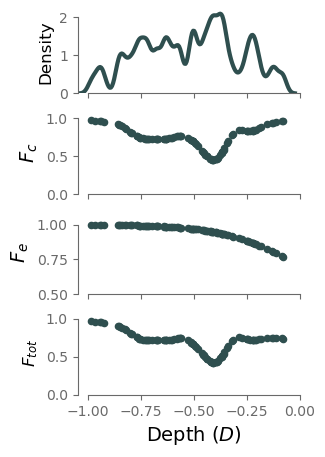

In [26]:
fig, axs = plt.subplots(4,1, sharex = True, figsize = (3,5))
ax = axs[0]
sns.kdeplot(D, ax = ax, bw_adjust = 0.2, color = 'darkslategrey', lw = 3)
#ax.hist(D,bins = 30)
ax.set_xlim(-1.05,0.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds(ax.get_yticks()[0],ax.get_yticks()[-2])
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_bounds(ax.get_xticks()[1],ax.get_xticks()[-2])
ax.spines['bottom'].set_color('dimgrey')
ax.set_ylabel('Density',fontsize = 12)
ax.tick_params(color = 'dimgrey', labelcolor = 'dimgrey')


ax = axs[1]
ax.scatter(D,Fc, color = 'darkslategrey', s = 20)
ax.set_ylim(0,1.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds(ax.get_yticks()[0],ax.get_yticks()[-2])
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_bounds(ax.get_xticks()[1],ax.get_xticks()[-2])
ax.spines['bottom'].set_color('dimgrey')
ax.set_ylabel('$F_c$',fontsize = 14)
ax.tick_params(color = 'dimgrey', labelcolor = 'dimgrey')

ax = axs[2]
ax.scatter(D,Fe, color = 'darkslategrey', s = 20)
ax.set_ylim(0.5,1.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds(ax.get_yticks()[0],ax.get_yticks()[-2])
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_bounds(ax.get_xticks()[1],ax.get_xticks()[-2])
ax.spines['bottom'].set_color('dimgrey')
ax.set_ylabel('$F_e$',fontsize = 14)
ax.tick_params(color = 'dimgrey', labelcolor = 'dimgrey')

ax = axs[3]
ax.scatter(D,Fe*Fc, color = 'darkslategrey', s = 20)
ax.set_ylim(0,1.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds(ax.get_yticks()[0],ax.get_yticks()[-2])
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_bounds(ax.get_xticks()[1],ax.get_xticks()[-2])
ax.spines['bottom'].set_color('dimgrey')
ax.set_ylabel('$F_{tot}$',fontsize = 12)
ax.tick_params(color = 'dimgrey', labelcolor = 'dimgrey')
ax.set_xlabel('Depth ($D$)', fontsize = 14)

plt.savefig('plots/model_schematic_fitness.pdf', bbox_inches = 'tight')

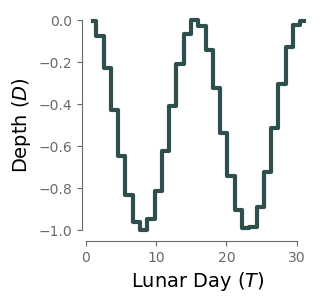

In [27]:
fig, ax = plt.subplots(figsize= (3,3))
x = np.linspace(1,31,30)
y = (np.sin(2*np.pi*(x/15) - 5))/2 - 0.5
ax.step(x,y,where = 'mid', lw = 3, c = 'darkslategrey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds(ax.get_yticks()[1],ax.get_yticks()[-2])
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_bounds(ax.get_xticks()[1],ax.get_xticks()[-2])
ax.spines['bottom'].set_color('dimgrey')
ax.set_ylabel('Depth ($D$)',fontsize = 14)
ax.tick_params(color = 'dimgrey', labelcolor = 'dimgrey')
ax.set_xlabel('Lunar Day ($T$)', fontsize = 14)
plt.savefig('plots/model_schematic_tides.pdf', bbox_inches = 'tight')

# Figure 2 - Single Run

In [2094]:
sim = ecology_model(sd = 0.25, Cw = 0.1, K = 100, mu = 0.18, N0 = 10, X0 = 15, Y0 = 0, gens = 500)
res, res_y = sim.simulate(return_array = True, return_Y = True)

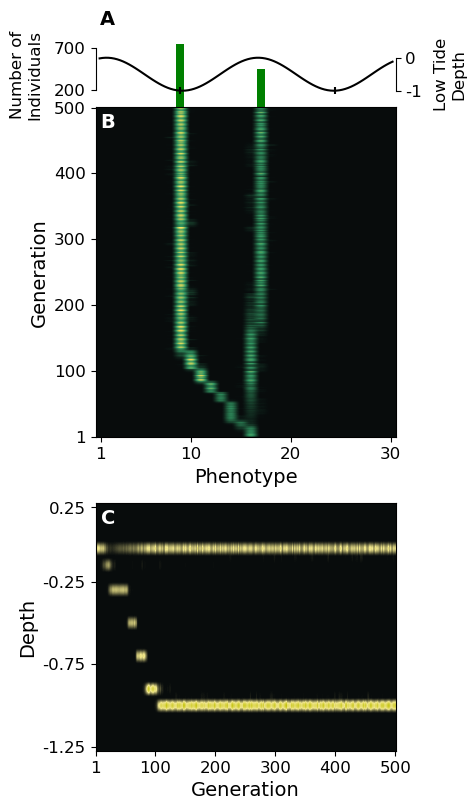

In [2097]:
fig = plt.figure(figsize = (3,3.3))

ax1_behind = fig.add_axes([0,1,1,0.2])
ax1 = fig.add_axes([0,1,1,0.2])

ax2 = fig.add_axes([0,0,1,1])

ax3 = fig.add_axes([0,-0.95,1,0.75])


ax1_behind.bar(range(30),res[-1], color = 'green')
for spine in ['top','bottom','right']:
        ax1_behind.spines[spine].set_visible(False)
ax1_behind.spines['left'].set_bounds(200,700)
ax1_behind.set_yticks([200,700],[200,700], fontsize = 12)
ax1_behind.set_xticks([])
ax1_behind.set_ylabel('Number of\nIndividuals', fontsize = 12, rotation = 90, labelpad = 20, va = 'center')
ax1_behind.set_xlim(-0.3,29.3)

x = np.linspace(0,29,100)
y = ((np.sin(2*np.pi*(x/15) - 5))/2 - 0.5)
ax1.plot(x,y, c = 'black')
ax1.set_ylim(-1.5,0.5)
ax1.set_xlim(-0.4,29.3)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_yticks([-1,0],['-1','0'], fontsize = 12)
ax1.set_xticks([])
ax1.set_ylabel('Low Tide\nDepth', fontsize = 12,rotation = 90, labelpad = 20, va = 'center')
for spine in ['top','bottom','left']:
        ax1.spines[spine].set_visible(False)
ax1.spines['right'].set_bounds(-1,0)
ax1.annotate('A',(0,1),fontsize = 14, fontweight = 'bold',annotation_clip = False)
ax1.vlines(8,-1.1,-0.9,color = 'black')
ax1.vlines(23.3,-1.1,-0.9,color = 'black')
ax1.patch.set_alpha(0)


ax2.imshow(np.flipud(res),aspect = 'auto', cmap = greens)
ax2.set_ylabel('Generation', fontsize = 14)
ax2.set_xlabel('Phenotype', fontsize = 14)
ax2.set_yticks([0,99,199,299,399,499],['500','400','300','200','100','1'], fontsize = 12)
ax2.set_xticks([0,9,19,29],['1','10','20','30'], fontsize = 12)
ax2.annotate('B',(0,30),fontsize = 14, fontweight = 'bold',annotation_clip = False, color = 'white')


ax3.imshow(np.rot90(res_y),aspect = 'auto', cmap = greens_alt)
ax3.set_xlabel('Generation', fontsize = 14)
ax3.set_ylabel('Depth', fontsize = 14)
ax3.set_xticks([0,99,199,299,399,499],['1','100','200','300','400','500'], fontsize = 12)
ax3.set_yticks([0,9,19,29],['0.25','-0.25','-0.75','-1.25'], fontsize = 12)
ax3.annotate('C',(8,2),fontsize = 14, fontweight = 'bold',annotation_clip = False, color = 'white')

plt.savefig('plots/singleRun_depthPheno.pdf', bbox_inches = 'tight')

# Figure 3 - Ecological Param Sweep - Eco vs Gen models

In [69]:
# generating Ecology model examples 
sim = ecology_model(sd = 0.075, Cw = 0.025, K = 100, mu = 0.18, N0 = 10, X0 = 15, Y0 = 0, gens = 500)
eco_res1 = sim.simulate(return_array = True)
np.save('CwSd_paramSweep_examples/eco_modelSd0.075_Cw0.025.npy', eco_res1)

sim = ecology_model(sd = 0.25, Cw = 0.1, K = 100, mu = 0.18, N0 = 10, X0 = 15, Y0 = 0, gens = 500)
eco_res2 = sim.simulate(return_array = True)
np.save('CwSd_paramSweep_examples/eco_modelSd0.25_Cw0.1.npy', eco_res2)

sim = ecology_model(sd = 0.9, Cw = 0.25, K = 100, mu = 0.18, N0 = 10, X0 = 15, Y0 = 0, gens = 500)
eco_res3 = sim.simulate(return_array = True)
np.save('CwSd_paramSweep_examples/eco_modelSd0.9_Cw0.25.npy', eco_res3)

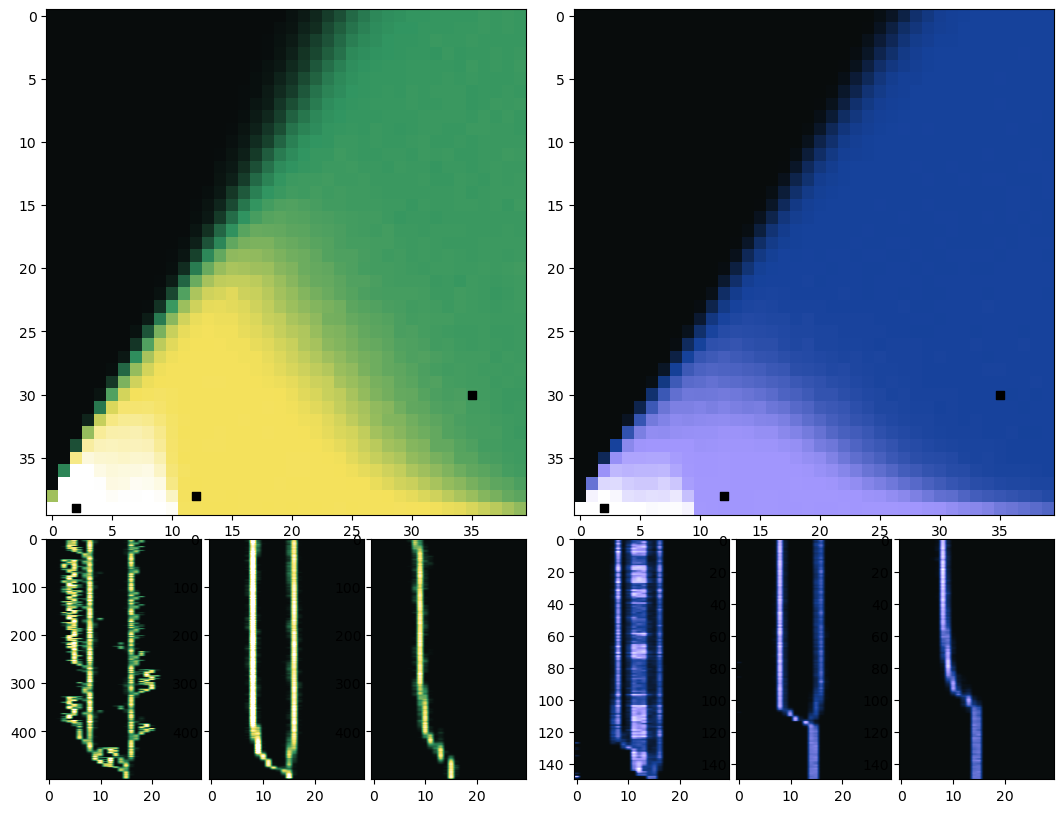

In [893]:
fig = plt.figure(figsize = (13,10))

gs_out = gridspec.GridSpec(1,2,wspace = 0.1,figure=fig)

gs_inL = gridspec.GridSpecFromSubplotSpec(3,6, hspace = 0.1, wspace = 0.1, subplot_spec=gs_out[0,0])

ax1 = fig.add_subplot(gs_inL[0:2,:])
ax1.imshow(np.flipud(np.mean(eco_res,axis = 0)),cmap = greens, vmax = 3, aspect = 'auto')
ax1.scatter([2,12,35],[39,38,30], c = 'black', marker = 's')

ax2 = fig.add_subplot(gs_inL[2,0:2])
ax2.imshow(np.flipud(eco_res1),cmap = greens, vmax = 500, aspect = 'auto')

ax3 = fig.add_subplot(gs_inL[2,2:4])
ax3.imshow(np.flipud(eco_res2),cmap = greens, vmax = 700, aspect = 'auto')

ax4 = fig.add_subplot(gs_inL[2,4:6])
ax4.imshow(np.flipud(eco_res3),cmap = greens, vmax = 500, aspect = 'auto')


gs_inR = gridspec.GridSpecFromSubplotSpec(3,6, hspace = 0.1, wspace = 0.1, subplot_spec=gs_out[0,1])

ax5 = fig.add_subplot(gs_inR[0:2,:])
ax5.imshow(np.flipud(np.mean(gen_res,axis = 0)),cmap = blues, vmax = 3,  aspect = 'auto')
ax5.scatter([2,12,35],[39,38,30], c = 'black', marker = 's')

ax6 = fig.add_subplot(gs_inR[2,0:2])
ax6.imshow(np.flipud(gen_ar1),cmap = blues, aspect = 'auto')

ax7 = fig.add_subplot(gs_inR[2,2:4])
ax7.imshow(np.flipud(gen_ar2),cmap = blues, aspect = 'auto')

ax8 = fig.add_subplot(gs_inR[2,4:6])
ax8.imshow(np.flipud(gen_ar3),cmap = blues, aspect = 'auto')

In [14]:
# loading in data 
files = glob('CwSd_ParamSweeps/Eco_CwSd_paramSweep_5kids_100k/*')
eco_sweep_res = np.load(files.pop(0))[None,:,:]
for file in files:
    eco_sweep_res = np.concatenate((eco_sweep_res,np.load(file)[None,:,:]),axis = 0)
    
files = glob('CwSd_ParamSweeps/Gen_CwSd_paramSweep_10kids_200K/*')
gen_sweep_res = np.load(files.pop(0))[None,:,:]
for file in files:
    gen_sweep_res = np.concatenate((gen_sweep_res,np.load(file)[None,:,:]),axis = 0)

eco_res1 = np.load('CwSd_paramSweep_examples/eco_modelSd0.075_Cw0.025.npy')
eco_res2 = np.load('CwSd_paramSweep_examples/eco_modelSd0.25_Cw0.1.npy')
eco_res3 = np.load('CwSd_paramSweep_examples/eco_modelSd0.9_Cw0.25.npy')

gen_ar1 = Parse2KDE('CwSd_paramSweep_examples/gen_modelSd_0.075_Cw_0.025.output','X')
gen_ar2 = Parse2KDE('CwSd_paramSweep_examples/gen_modelSd_0.25_Cw_0.1.output','X')
gen_ar3 = Parse2KDE('CwSd_paramSweep_examples/gen_modelSd_0.9_Cw_0.25.output','X')

pca_df1 = get_pca('Sd_0.075_Cw_0.025')
pca_df2 = get_pca('Sd_0.25_Cw_0.1')
pca_df3 = get_pca('Sd_0.9_Cw_0.25')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


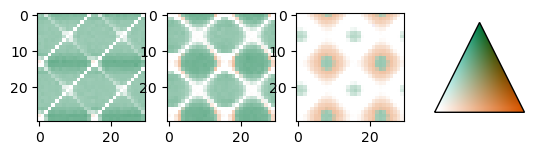

In [15]:
# setting up 2d colormap and loading pips 
primary_system1 = (1, 0, 0)
primary_system2 = (0, 1, 0)
primary_system3 = (0, 0, 1)
primary_system4 = (0.33, 0.33, 0.33)

secondary_system1 = (215,87,0) #invasion
secondary_system2 = (0,119,63) #coexistance
secondary_system3 = (255, 255, 255) #non-invasion
secondary_system4 = (0,0,200) #intermediate


transformFn = solve_affine( primary_system1, primary_system2, 
                            primary_system3, primary_system4,
                            secondary_system1, secondary_system2,
                            secondary_system3, secondary_system4 )

pip1 = make_pip_array('pips/Cw0.025-sd0.075_rep*.npy',transformFn)
pip2 = make_pip_array('pips/Cw0.1-sd0.25_rep*.npy',transformFn)
pip3 = make_pip_array('pips/Cw0.25-sd0.9_rep*.npy',transformFn)

fig,axs = plt.subplots(1,4)
axs[0].imshow(np.flipud(pip1))
axs[1].imshow(np.flipud(pip2))
axs[2].imshow(np.flipud(pip3))
get_color_triangle(axs[3],transformFn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


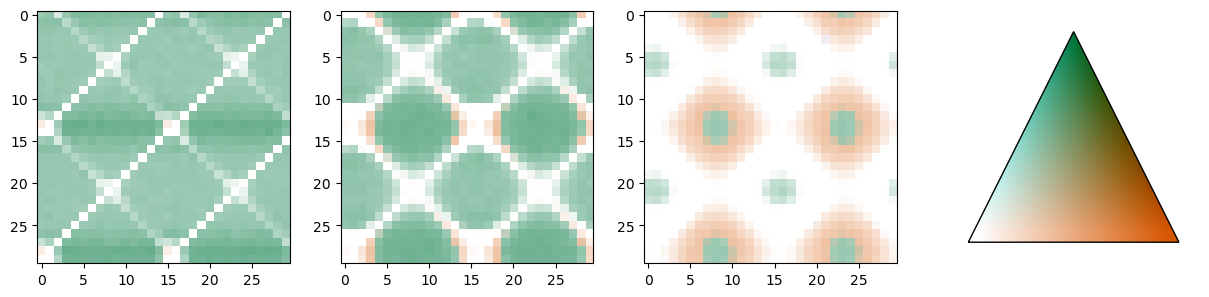

In [1762]:
fig,axs = plt.subplots(1,4, figsize = (15,5))
axs[0].imshow(np.flipud(pip1))
axs[1].imshow(np.flipud(pip2))
axs[2].imshow(np.flipud(pip3))
get_color_triangle(axs[3],transformFn)

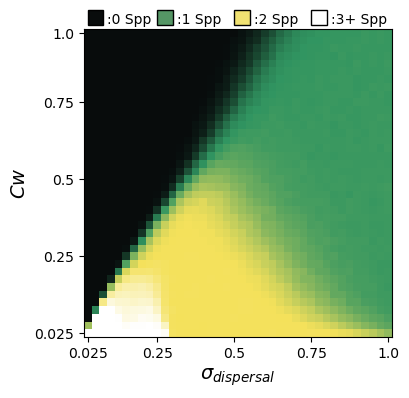

In [16]:
# making eco sweep plot
fig,ax = plt.subplots(1,1,figsize = (4,4))
ax.imshow(np.flipud(np.mean(eco_sweep_res,axis = 0)),cmap = greens, vmax = 3)
#ax.scatter([2,9,35],[39,36,30], c = 'black', marker = 's')
ax.set_xlabel('$\sigma_{dispersal}$', fontsize = 14)
ax.set_ylabel('$Cw$', fontsize = 14)
ax.set_xticks([0,9,19,29,39],[0.025,0.25,0.5,0.75,1.0])
ax.set_yticks([39,29,19,9,0],[0.025,0.25,0.5,0.75,1.0])

ax.add_patch(Rectangle((0, -3),2,2, clip_on = False, facecolor = (9/255,12/255,12/255), edgecolor = 'black'))
ax.annotate(':0 Spp',(2.5,-1.2), annotation_clip = False)

ax.add_patch(Rectangle((9, -3),2,2, clip_on = False, facecolor = (85/255,150/255,101/255), edgecolor = 'black'))
ax.annotate(':1 Spp',(11.5,-1.2), annotation_clip = False)

ax.add_patch(Rectangle((19, -3),2,2, clip_on = False, facecolor = (241/255,226/255,114/255), edgecolor = 'black'))
ax.annotate(':2 Spp',(21.5,-1.2), annotation_clip = False)

ax.add_patch(Rectangle((29, -3),2,2, clip_on = False, facecolor = (1,1,1), edgecolor = 'black'))
ax.annotate(':3+ Spp',(31.5,-1.2), annotation_clip = False)

plt.savefig('plots/CwSd_paramSweep/eco_sweep_notDots.pdf', bbox_inches = 'tight')

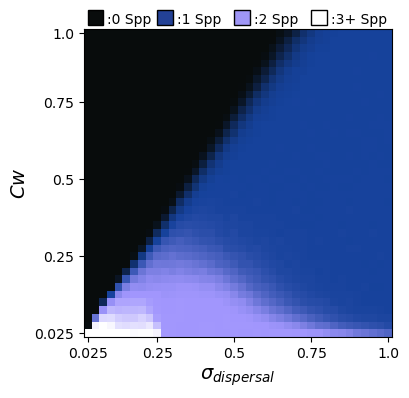

In [17]:
fig,ax = plt.subplots(1,1,figsize = (4,4))
ax.imshow(np.flipud(np.mean(gen_sweep_res,axis = 0)),cmap = blues, vmax = 3)
#ax.scatter([2,9,35],[39,36,30], c = 'black', marker = 's')
ax.set_xlabel('$\sigma_{dispersal}$', fontsize = 14)
ax.set_ylabel('$Cw$', fontsize = 14)
ax.set_xticks([0,9,19,29,39],[0.025,0.25,0.5,0.75,1.0])
ax.set_yticks([39,29,19,9,0],[0.025,0.25,0.5,0.75,1.0])

ax.add_patch(Rectangle((0, -3),2,2, clip_on = False, facecolor = (9/255,12/255,12/255), edgecolor = 'black'))
ax.annotate(':0 Spp',(2.5,-1.2), annotation_clip = False)

ax.add_patch(Rectangle((9, -3),2,2, clip_on = False, facecolor = (35/255,65/255,150/255), edgecolor = 'black'))
ax.annotate(':1 Spp',(11.5,-1.2), annotation_clip = False)

ax.add_patch(Rectangle((19, -3),2,2, clip_on = False, facecolor = (159/255,150/255,246/255), edgecolor = 'black'))
ax.annotate(':2 Spp',(21.5,-1.2), annotation_clip = False)

ax.add_patch(Rectangle((29, -3),2,2, clip_on = False, facecolor = (1,1,1), edgecolor = 'black'))
ax.annotate(':3+ Spp',(31.5,-1.2), annotation_clip = False)

plt.savefig('plots/CwSd_paramSweep/gen_sweep_noDots.pdf', bbox_inches = 'tight')

In [1771]:
## Fixing pheno order in pips to go 1 to 30 instead of 0 to 29 
pip1 = np.hstack((pip1[:,1:,:],pip1[:,0,:][:,np.newaxis,:]))
pip1 = np.vstack((pip1[1:,:,:],pip1[0,:,:][np.newaxis,:,:]))

pip2 = np.hstack((pip2[:,1:,:],pip2[:,0,:][:,np.newaxis,:]))
pip2 = np.vstack((pip2[1:,:,:],pip2[0,:,:][np.newaxis,:,:]))

pip3 = np.hstack((pip3[:,1:,:],pip3[:,0,:][:,np.newaxis,:]))
pip3 = np.vstack((pip3[1:,:,:],pip3[0,:,:][np.newaxis,:,:]))


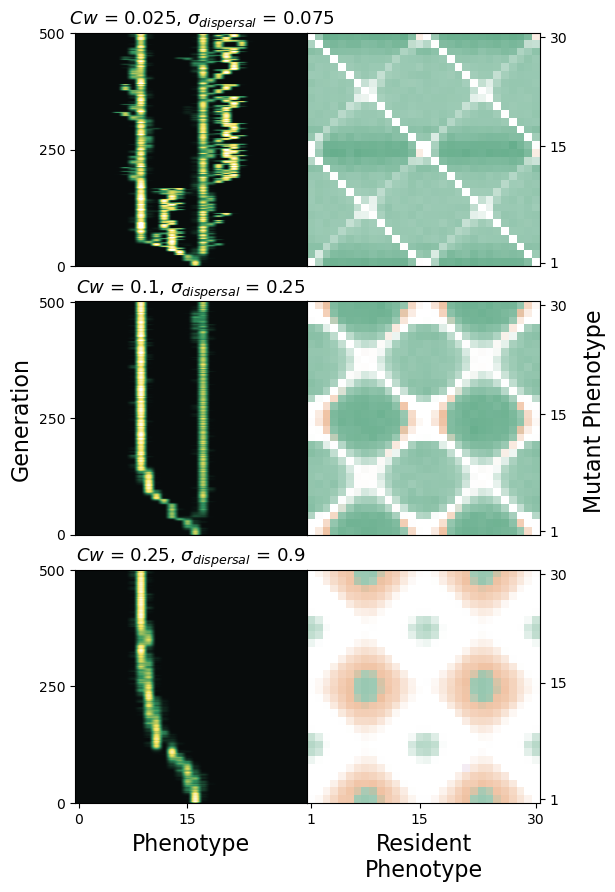

In [1772]:
fig = plt.figure(figsize = (6,10))

gs_out = gridspec.GridSpec(3,1,hspace = 0.15,figure=fig)

gs_inT = gridspec.GridSpecFromSubplotSpec(1,4, hspace = 0, wspace = 0, subplot_spec=gs_out[0,0])
ax1 = fig.add_subplot(gs_inT[0,:2])
ax1.imshow(np.flipud(eco_res1),cmap = greens, vmax = 500, aspect = 'auto')
ax1.set_title('    $Cw$ = 0.025, $\sigma_{dispersal}$ = 0.075', fontsize = 13)
ax2 = fig.add_subplot(gs_inT[0,2:])
ax2.imshow(np.flipud(np.flipud(pip1)), aspect = 'auto')

gs_inM = gridspec.GridSpecFromSubplotSpec(1,4, hspace = 0, wspace = 0, subplot_spec=gs_out[1,0])
ax3 = fig.add_subplot(gs_inM[0,:2])
ax3.imshow(np.flipud(eco_res2),cmap = greens, vmax = 500, aspect = 'auto')
ax3.set_title('$Cw$ = 0.1, $\sigma_{dispersal}$ = 0.25', fontsize = 13)
ax4 = fig.add_subplot(gs_inM[0,2:])
ax4.imshow(np.flipud(np.flipud(pip2)), aspect = 'auto')

gs_inB = gridspec.GridSpecFromSubplotSpec(1,4, hspace = 0, wspace = 0, subplot_spec=gs_out[2,0])
ax5 = fig.add_subplot(gs_inB[0,:2])
ax5.imshow(np.flipud(eco_res3),cmap = greens, vmax = 500, aspect = 'auto')
ax5.set_title('$Cw$ = 0.25, $\sigma_{dispersal}$ = 0.9', fontsize = 13)
ax6 = fig.add_subplot(gs_inB[0,2:])
ax6.imshow(np.flipud(np.flipud(pip3)), aspect = 'auto')

for ax in [ax1,ax3,ax5]:
    ax.set_yticks([499,249,0],[0,250,500])
    ax.set_xticks([])
ax5.set_xticks([0,14],[0,15])
ax5.set_xlabel('Phenotype', fontsize = 16)
ax3.set_ylabel('Generation', fontsize = 16)
                   
for ax in [ax2,ax4,ax6]:
    ax.yaxis.tick_right()
    ax.set_yticks([29,14,0],[1,15,30])
    ax.set_xticks([])
ax6.set_xticks([0,14,29],[1,15,30])
ax6.set_xlabel('Resident\nPhenotype', fontsize = 16)
ax4.annotate('Mutant Phenotype',(35,26), rotation = 90, fontsize = 16, annotation_clip = False)

plt.savefig('plots/CwSd_paramSweep/pips.pdf',bbox_inches = 'tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


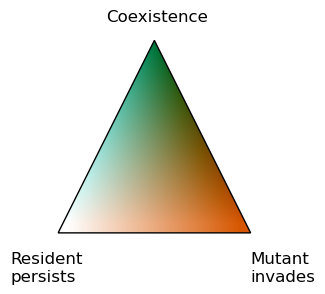

In [285]:
fig,ax = plt.subplots(1,1,figsize = (3,3))
get_color_triangle(ax,transformFn)
ax.annotate('Resident\npersists',(-0.25,-0.25),fontsize = 12, annotation_clip = False)
ax.annotate('Mutant\ninvades',(1,-0.25),fontsize = 12, annotation_clip = False)
ax.annotate('Coexistence',(0.25,1.1),fontsize = 12, annotation_clip = False)
plt.savefig('plots/CwSd_paramSweep/color_triangle.pdf', bbox_inches = 'tight')

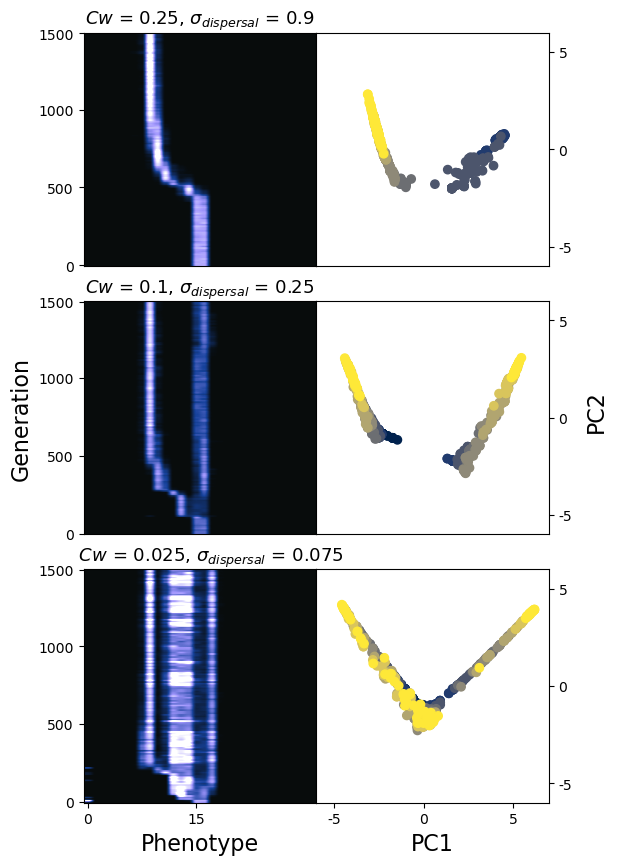

In [1537]:
fig = plt.figure(figsize = (6,10))

gs_out = gridspec.GridSpec(3,1,hspace = 0.15,figure=fig)

gs_inT = gridspec.GridSpecFromSubplotSpec(1,4, hspace = 0, wspace = 0, subplot_spec=gs_out[0,0])
ax1 = fig.add_subplot(gs_inT[0,:2])
ax1.imshow(np.flipud(gen_ar3),cmap = blues, vmax = 700, aspect = 'auto')
ax1.set_title('$Cw$ = 0.25, $\sigma_{dispersal}$ = 0.9', fontsize = 13)
ax2 = fig.add_subplot(gs_inT[0,2:])
ax2.scatter(pca_df3['pc1'],pca_df3['pc2'], c = pca_df3['gen'], cmap = 'cividis')#, s = pca_df1['gen']/30, alpha = 0.8)

gs_inM = gridspec.GridSpecFromSubplotSpec(1,4, hspace = 0, wspace = 0, subplot_spec=gs_out[1,0])
ax3 = fig.add_subplot(gs_inM[0,:2])
ax3.imshow(np.flipud(gen_ar2),cmap = blues, vmax = 700, aspect = 'auto')
ax3.set_title('$Cw$ = 0.1, $\sigma_{dispersal}$ = 0.25', fontsize = 13)
ax4 = fig.add_subplot(gs_inM[0,2:])
ax4.scatter(pca_df2['pc1'],pca_df2['pc2'], c = pca_df2['gen'], cmap = 'cividis')#, s = pca_df2['gen']/30, alpha = 0.8)


gs_inB = gridspec.GridSpecFromSubplotSpec(1,4, hspace = 0, wspace = 0, subplot_spec=gs_out[2,0])
ax5 = fig.add_subplot(gs_inB[0,:2])
ax5.imshow(np.flipud(gen_ar1),cmap = blues, vmax = 700, aspect = 'auto')
ax5.set_title('    $Cw$ = 0.025, $\sigma_{dispersal}$ = 0.075', fontsize = 13)
ax6 = fig.add_subplot(gs_inB[0,2:])
ax6.scatter(pca_df1['pc1'],pca_df1['pc2'], c = pca_df1['gen'], cmap = 'cividis')#, s = pca_df3['gen']/30, alpha = 0.8)

for ax in [ax1,ax3,ax5]:
    ax.set_yticks([149,99,49,0],[0,500,1000,1500])
    ax.set_xticks([])
ax5.set_xticks([0,14],[0,15])
ax5.set_xlabel('Phenotype', fontsize = 16)
ax3.set_ylabel('Generation', fontsize = 16)
                   
for ax in [ax2,ax4,ax6]:
    ax.yaxis.tick_right()
    ax.set_yticks([-5,0,5],[-5,0,5])
    ax.set_ylim(-6,6)
    ax.set_xticks([])
    ax.set_xlim(-6,7)
ax6.set_xticks([-5,0,5],[-5,0,5])
ax6.set_xlabel('PC1', fontsize = 16)
ax4.annotate('PC2',(9,-0.5), rotation = 90, fontsize = 16, annotation_clip = False)

plt.savefig('plots/CwSd_paramSweep/pcas.pdf', bbox_inches = 'tight')

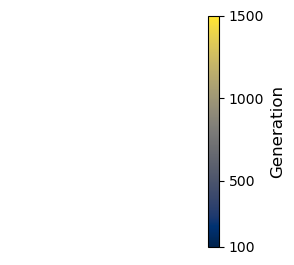

In [283]:
gens = [100,1500]
fig, ax = plt.subplots(1,1,figsize = (3,3))
dots = ax.scatter([1,1],[1,1],c = gens, cmap = 'cividis', s = 0)
ax.axis('off')
cb = plt.colorbar(dots)
cb.set_label('Generation', fontsize = 12)
cb.set_ticks([100,500,1000,1500], labels = [100,500,1000,1500], fontsize = 10)
plt.savefig('plots/CwSd_paramSweep/color_bar.pdf',bbox_inches = 'tight')

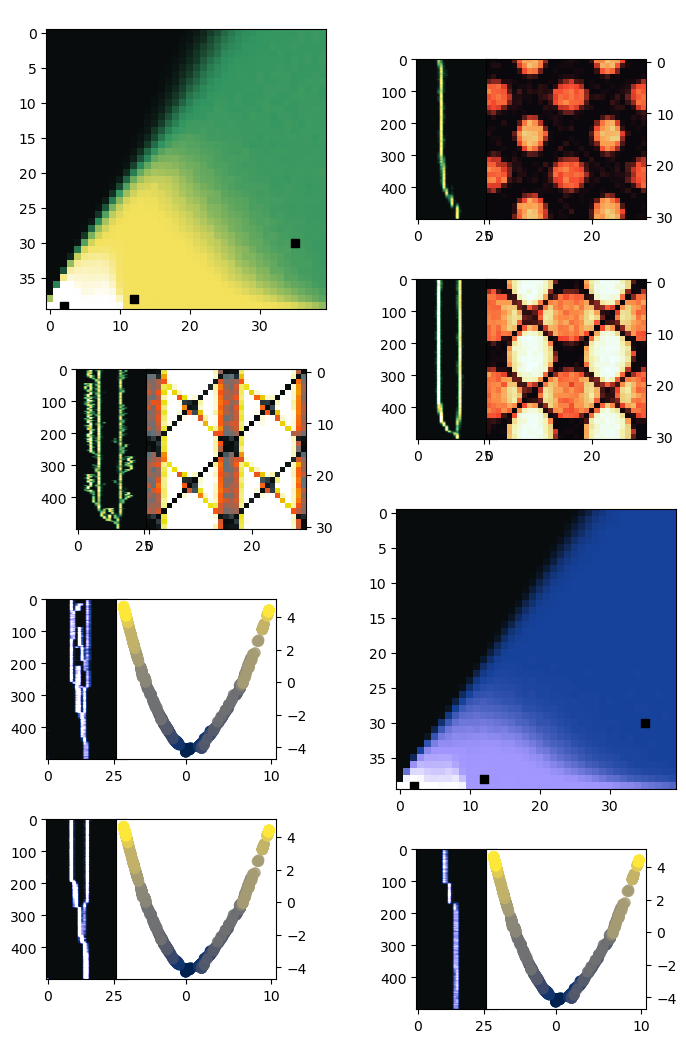

In [856]:
fig = plt.figure(figsize = (10,10))

s_size = 0.16
l_size = 0.28


behind_ax = fig.add_axes([0,0,0.6,1])
behind_ax.axis('off')

ax1 = fig.add_axes([0,0.7,l_size,l_size])
ax11a = fig.add_axes([0.03,0.48,s_size/2,s_size])
ax11b = fig.add_axes([0.03 + 0.07,0.48,s_size,s_size])
ax12a = fig.add_axes([0.37,0.57,s_size/2,s_size])
ax12b = fig.add_axes([0.37 + 0.07,0.57,s_size,s_size])
ax13a = fig.add_axes([0.37,0.79,s_size/2,s_size])
ax13b = fig.add_axes([0.37 + 0.07,0.79,s_size,s_size])

ax1.imshow(np.flipud(np.mean(eco_res,axis = 0)),cmap = greens, vmax = 3, aspect = 'auto')
ax1.scatter([2,12,35],[39,38,30], c = 'black', marker = 's')
ax11a.imshow(np.flipud(eco_res1),cmap = greens, vmax = 500, aspect = 'auto')
ax11b.imshow(np.rot90(pip1.sort_values(by = [0,1])[3].to_numpy().reshape(31,31)), cmap = transition, vmax = 100, aspect = 'auto')
ax12a.imshow(np.flipud(eco_res2),cmap = greens, vmax = 700, aspect = 'auto')
ax12b.imshow(np.rot90(pip2.sort_values(by = [0,1])[3].to_numpy().reshape(31,31)), cmap = flare, vmax = 100, aspect = 'auto')
ax13a.imshow(np.flipud(eco_res3),cmap = greens, vmax = 500, aspect = 'auto')
ax13b.imshow(np.rot90(pip3.sort_values(by = [0,1])[3].to_numpy().reshape(31,31)), cmap = flare, vmax = 100, aspect = 'auto')

ax2 = fig.add_axes([0.35,0.22,l_size,l_size])
ax21a = fig.add_axes([0.37,0,s_size/2,s_size])
ax21b = fig.add_axes([0.37 + 0.07,0,s_size,s_size])
ax22a = fig.add_axes([0,0.03,s_size/2,s_size])
ax22b = fig.add_axes([0.0 + 0.07,0.03,s_size,s_size])
ax23a = fig.add_axes([0.0,0.25,s_size/2,s_size])
ax23b = fig.add_axes([0.0 + 0.07,0.25,s_size,s_size])

ax2.imshow(np.flipud(np.mean(gen_res,axis = 0)),cmap = blues, vmax = 3,  aspect = 'auto')
ax2.scatter([2,12,35],[39,38,30], c = 'black', marker = 's')
ax21a.imshow(np.flipud(gen_ar3),cmap = blues, vmax = 150, aspect = 'auto')
ax21b.scatter(pca_df['pc1'],pca_df['pc2'], c = pca_df['gen'], cmap = 'cividis', s = 50, alpha = 0.8)
ax22a.imshow(np.flipud(gen_ar2),cmap = blues, vmax = 150, aspect = 'auto')
ax22b.scatter(pca_df['pc1'],pca_df['pc2'], c = pca_df['gen'], cmap = 'cividis', s = 50, alpha = 0.8)
ax23a.imshow(np.flipud(gen_ar1),cmap = blues, vmax = 150, aspect = 'auto')
ax23b.scatter(pca_df['pc1'],pca_df['pc2'], c = pca_df['gen'], cmap = 'cividis', s = 50, alpha = 0.8)


for ax in [ax11b,ax12b,ax13b,ax21b,ax22b,ax23b]:
    ax.yaxis.tick_right()

Text(0.5, 0, 'PC1')

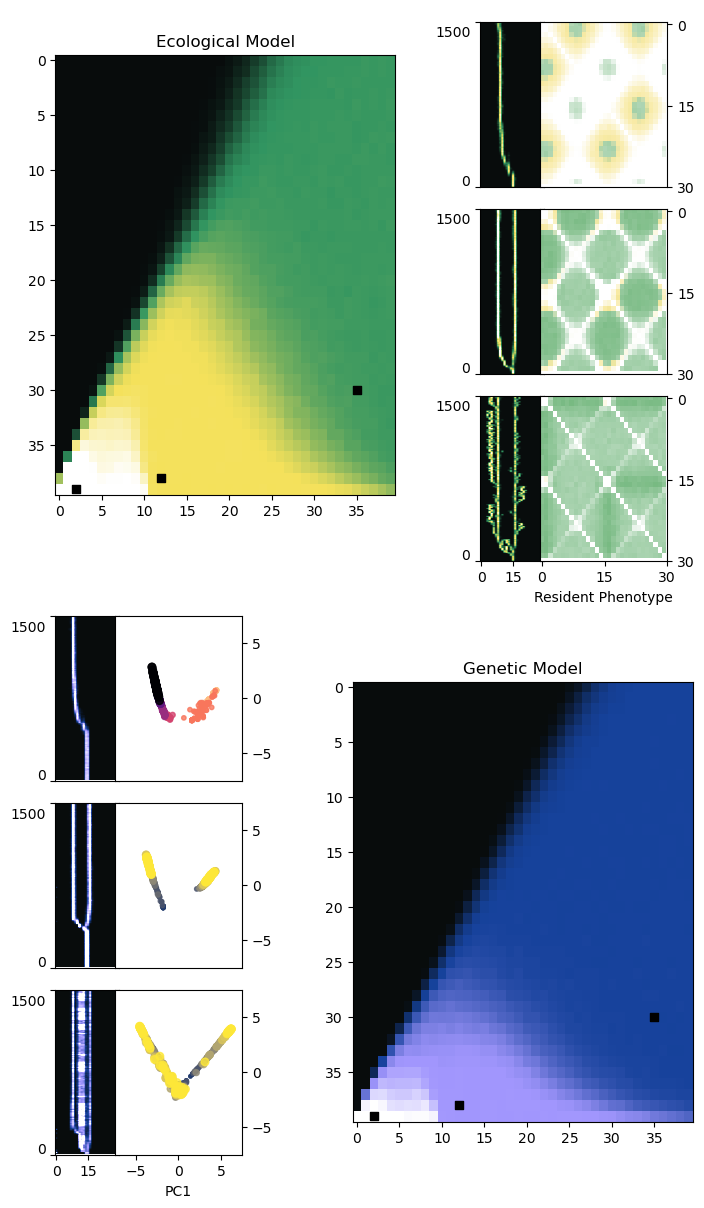

In [1946]:
fig = plt.figure(figsize = (8.5,11))

small_size = 0.15
large_size = 0.4



behind_ax = fig.add_axes([0,0,0.6,1])
behind_ax.axis('off')

ax1 = fig.add_axes([0,0.6,large_size,large_size])
ax11a = fig.add_axes([0.5,0.88,small_size/2,small_size])
ax11b = fig.add_axes([0.57,0.88,small_size,small_size])
ax12a = fig.add_axes([0.5,0.71,small_size/2,small_size])
ax12b = fig.add_axes([0.57,0.71,small_size,small_size])
ax13a = fig.add_axes([0.5,0.54,small_size/2,small_size])
ax13b = fig.add_axes([0.57,0.54,small_size,small_size])

ax1.imshow(np.flipud(np.mean(eco_res,axis = 0)),cmap = greens, vmax = 3, aspect = 'auto')
ax1.scatter([2,12,35],[39,38,30], c = 'black', marker = 's')
ax1.set_title('Ecological Model', fontsize = 12)

ax11a.imshow(np.flipud(eco_res3),cmap = greens, vmax = 500, aspect = 'auto')
ax11b.imshow(pip3, aspect = 'auto')
ax12a.imshow(np.flipud(eco_res2),cmap = greens, vmax = 700, aspect = 'auto')
ax12b.imshow(pip2, aspect = 'auto')
ax13a.imshow(np.flipud(eco_res1),cmap = greens, vmax = 500, aspect = 'auto')
ax13b.imshow(pip1, aspect = 'auto')

ax2 = fig.add_axes([0.35,0.03,large_size,large_size])
ax21a = fig.add_axes([0.0,2*small_size + 0.04,small_size/2,small_size])
ax21b = fig.add_axes([0.07,2*small_size + 0.04,small_size,small_size])
ax22a = fig.add_axes([0.0,small_size + 0.02,small_size/2,small_size])
ax22b = fig.add_axes([0.07,small_size+ 0.02,small_size,small_size])
ax23a = fig.add_axes([0,0,small_size/2,small_size])
ax23b = fig.add_axes([0.07,0,small_size,small_size])

ax2.imshow(np.flipud(np.mean(gen_res,axis = 0)),cmap = blues, vmax = 3,  aspect = 'auto')
ax2.scatter([2,12,35],[39,38,30], c = 'black', marker = 's')
ax2.set_title('Genetic Model', fontsize = 12)

ax21a.imshow(np.flipud(gen_ar3),cmap = blues, vmax = 600, aspect = 'auto')
ax21b.scatter(pca_df3['pc1'],pca_df3['pc2'], c = pca_df3['gen'], cmap = 'magma_r', s = pca_df1['gen']/50, alpha = 0.8)
ax22a.imshow(np.flipud(gen_ar2),cmap = blues, vmax = 600, aspect = 'auto')
ax22b.scatter(pca_df2['pc1'],pca_df2['pc2'], c = pca_df2['gen'], cmap = 'cividis', s = pca_df1['gen']/50, alpha = 0.8)
ax23a.imshow(np.flipud(gen_ar1),cmap = blues, vmax = 600, aspect = 'auto')
ax23b.scatter(pca_df1['pc1'],pca_df1['pc2'], c = pca_df1['gen'], cmap = 'cividis', s = pca_df1['gen']/50, alpha = 0.8)


for ax in [ax11b,ax12b,ax13b]:
    ax.yaxis.tick_right()
    ax.set_xticks([0,15,30],[0,15,30])
    ax.set_yticks([0,15,30],[0,15,30])
    
for ax in [ax21b,ax22b,ax23b]:
    ax.yaxis.tick_right()
    
for ax in [ax11a,ax12a,ax13a]:
    ax.set_yticks([0,500],['\n1500','0\n'])
    ax.set_xticks([0,15],[0,15])
    
for ax in [ax21a,ax22a,ax23a]:
    ax.set_yticks([0,150],['\n1500','0\n'])
    ax.set_xticks([0,15],[0,15])
    
for ax in [ax21b,ax22b,ax23b]:
    ax.set_ylim(-7.5,7.5)
    ax.set_xlim(-7.5,7.5)
    
for ax in [ax11a,ax11b,ax12a,ax12b,ax21a,ax21b,ax22a,ax22b]:
    ax.set_xticks([])

ax13b.set_xlabel('Resident Phenotype')
ax23b.set_xlabel('PC1')



# Figure 4 - Genetic Parameter Space 

In [3]:
files = glob('Gen_paramSweep/*')
gen_sweep_res = np.load(files.pop(0))[None,:,:]
for file in files:
    gen_sweep_res = np.concatenate((gen_sweep_res,np.load(file)[None,:,:]),axis = 0)

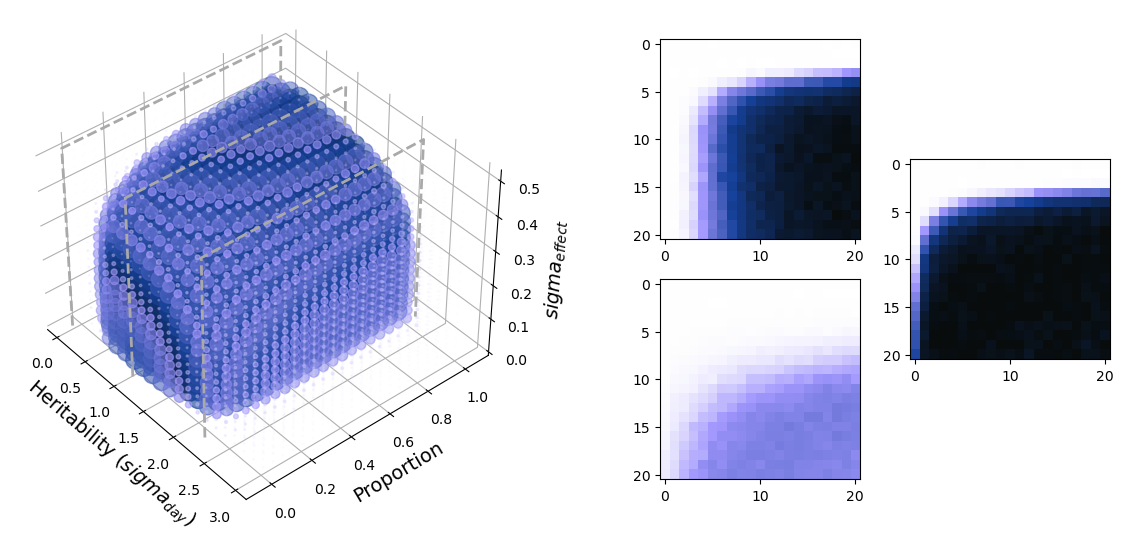

In [465]:
z = np.repeat(np.linspace(0.01,0.5,21),21*21)
x = np.tile(np.linspace(0,3,21),21*21)
y = np.tile(np.repeat(np.linspace(0.01,1,21),21),21)

arr = np.flipud(np.nanmean(gen_sweep_res,axis=0))
col = arr.flatten(order = 'C')
sig_val = 1/(1 + np.exp(-30*col + 8))
 
# Creating figure
fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_axes(rect = [0,0,0.5,0.5], projection ="3d")
ax1_over = fig.add_axes(rect = [0,0,0.5,0.5], projection ="3d")
ax2 = fig.add_axes([0.65,0.27,0.20,0.20])
ax3 = fig.add_axes([0.9,0.15,0.20,0.20])
ax4 = fig.add_axes([0.65,0.03,0.20,0.20])

ax1.scatter3D(x, y, z, c = col, s = sig_val*200, cmap = blues_r)
#ax.grid(False)
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.set_xlabel('Heritability ($sigma_{day}$)', fontsize = 14)
ax1.set_ylabel('Proportion', fontsize = 14)
ax1.set_zlabel('$sigma_{effect}$', fontsize = 14)
ax1.view_init(40, -40)
ax1.set_xlim(-0.1,3.1)
ax1.set_ylim(-0.1,1.1)
ax1.set_zlim(0,0.52)

ax1_over.plot3D([0,0,0,0],[0,0,1,1],[0,0.5,0.5,0.39], color = 'darkgrey', alpha = 1, lw = 2, ls = '--')
ax1_over.plot3D([1.05,1.05,1.05,1.05],[0,0,1,1],[0,0.5,0.5,0.39], color = 'darkgrey', alpha = 1, lw = 2, ls = '--')
ax1_over.plot3D([2.25,2.25,2.25,2.25],[0,0,1,1],[0,0.5,0.5,0], color = 'darkgrey', alpha = 1, lw = 2, ls = '--')
ax1_over.set_xlim(-0.1,3.1)
ax1_over.axis('off')
ax1_over.patch.set_alpha(0)
ax1_over.view_init(40, -40)

ax2.imshow(np.flipud(arr[:,:,0]), vmax = 0.5, cmap = blues_r)

ax3.imshow(np.flipud(arr[:,:,7]), vmax = 0.5, cmap = blues_r)

ax4.imshow(np.flipud(arr[:,:,15]), vmax = 0.5, cmap = blues_r)

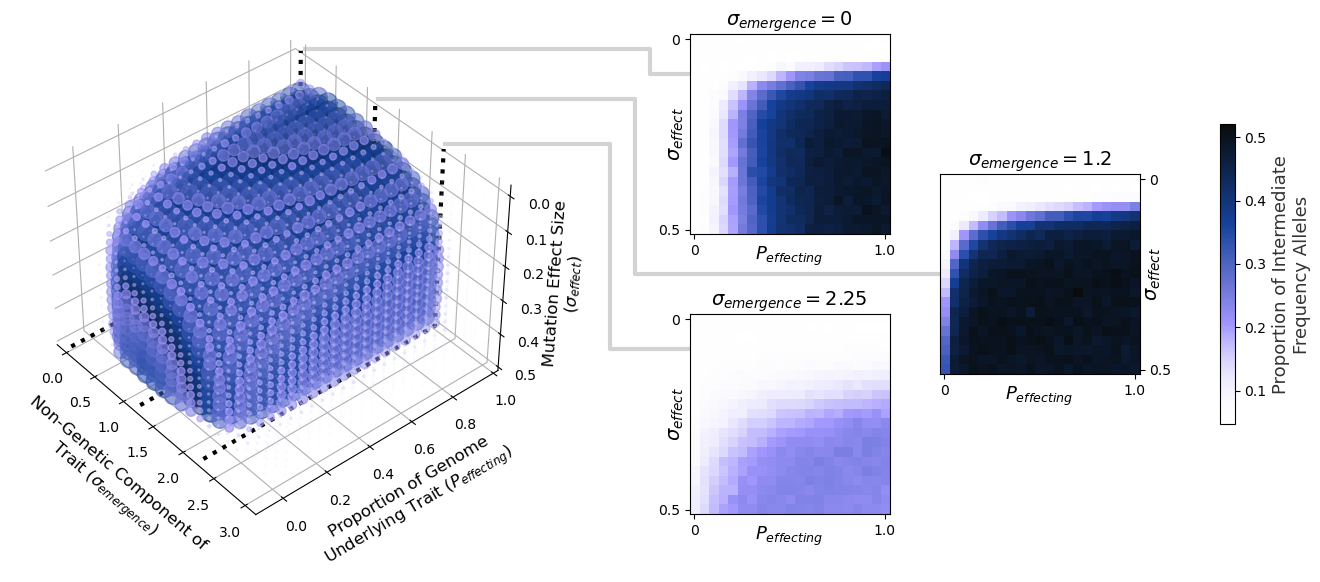

In [4]:
z = np.repeat(np.linspace(0.01,0.5,21),21*21)
x = np.tile(np.linspace(0,3,21),21*21)
y = np.tile(np.repeat(np.linspace(0.01,1,21),21),21)

arr = np.flipud(np.nanmean(gen_sweep_res,axis=0))
col = arr.flatten(order = 'C')
sig_val = 1/(1 + np.exp(-30*col + 8))
 
# Creating figure
fig = plt.figure(figsize = (10, 10))

ax_behind = fig.add_axes([0,0,1,0.5])
ax1 = fig.add_axes(rect = [0,0,0.5,0.5], projection ="3d")
ax2 = fig.add_axes([0.67,0.29,0.20,0.20])
ax3 = fig.add_axes([0.92,0.15,0.20,0.20])
ax4 = fig.add_axes([0.67,0.01,0.20,0.20])

ax_behind.plot([0.285,0.63,0.63,0.7],[0.95,0.95,0.9,0.9], c = 'lightgrey', lw = 3)
ax_behind.plot([0.358,0.615,0.615,1],[0.85,0.85,0.5,0.5], c = 'lightgrey', lw = 3)
ax_behind.plot([0.425,0.59,0.59,0.7],[0.76,0.76,0.35,0.35], c = 'lightgrey', lw = 3)
ax_behind.set_xlim(0,1)
ax_behind.set_ylim(0,1)
ax_behind.axis('off')

ax1.scatter3D(x, y, z, c = col, s = sig_val*200, cmap = blues_r)
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.set_zticks([0.0,0.1,0.2,0.3,0.4,0.5],['0.5','0.4','0.3','0.2','0.1','0.0'])
ax1.set_xlabel('Non-Genetic Component of\nTrait ($σ_{emergence}$)', fontsize = 12, labelpad = 12)
ax1.set_ylabel('Proportion of Genome\nUnderlying Trait ($P_{effecting}$)', fontsize = 12, labelpad = 10)
ax1.set_zlabel('Mutation Effect Size\n($σ_{effect}$)', fontsize = 12)
ax1.view_init(40, -40)
ax1.set_xlim(-0.1,3.1)
ax1.set_ylim(-0.1,1)
ax1.set_zlim(0,0.52)
ax1.patch.set_alpha(0)

ax1.plot3D([0,0,0],[-0.1,1,1],[0,0,0.52], color = 'black', lw = 3, ls = ':')
ax1.plot3D([1.2,1.2,1.2],[-0.1,1,1],[0,0,0.52], color = 'black', lw = 3, ls = ':')
ax1.plot3D([2.25,2.25,2.25],[-0.1,1,1],[0,0,0.52], color = 'black', lw = 3, ls = ':')

ax2.imshow(np.flipud(arr[:,:,0]), vmax = 0.52, cmap = blues_r)
ax2.set_title('$σ_{emergence}=0$', fontsize = 14)
ax2.set_yticks([0,20],[0,0.5])
ax2.set_xticks([0,20],[0,1.0])
ax2.set_ylabel('$σ_{effect}$', fontsize = 14, labelpad = -20)
ax2.set_xlabel('$P_{effecting}$', fontsize = 13, labelpad = -10)

ax3.imshow(np.flipud(arr[:,:,8]), vmax = 0.52, cmap = blues_r)
ax3.set_title('$σ_{emergence}=1.2$', fontsize = 14)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_yticks([0,20],[0,0.5])
ax3.set_xticks([0,20],[0,1.0])
ax3.set_ylabel('$σ_{effect}$', fontsize = 14, labelpad = -20)
ax3.set_xlabel('$P_{effecting}$', fontsize = 13, labelpad = -10)

heatmap = ax4.imshow(np.flipud(arr[:,:,15]), vmax = 0.52, cmap = blues_r)
ax4.set_title('$σ_{emergence}=2.25$', fontsize = 14)
ax4.set_yticks([0,20],[0,0.5])
ax4.set_xticks([0,20],[0,1.0])
ax4.set_ylabel('$σ_{effect}$', fontsize = 14, labelpad = -20)
ax4.set_xlabel('$P_{effecting}$', fontsize = 13, labelpad = -10)

cbar_ax = fig.add_axes([1.03,0.1,0.2,0.3])
cb = plt.colorbar(heatmap, ax = cbar_ax)
cbar_ax.patch.set_alpha(0)
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar_ax.yaxis.set_ticks_position('left')
#cbar_ax.yaxis.set_label_position("left")
cb.set_label('Proportion of Intermediate\nFrequency Alleles', fontsize = 13, alpha = 0.8)

# ax_behind.annotate('A',(0.04,0.8),fontweight = 'bold', fontsize = 16)
# ax2.annotate('B',(0.2,2), fontweight = 'bold', fontsize = 16)
# ax3.annotate('C',(0.2,2), fontweight = 'bold', fontsize = 16)
# ax4.annotate('D',(0.2,2), fontweight = 'bold', fontsize = 16)

plt.savefig('plots/genetic_parameter_space_noLables.pdf', bbox_inches = 'tight')

# Figure 5 - Initial States 

In [1]:
def count_peaks_from_hist(Xs):
    peaks = 0
    prev = 0
    going_up = True
    for num in Xs:
        if (num < prev) and going_up:
            peaks += 1
            going_up = False
        if (num > prev):
            going_up = True
        prev = num
    return peaks

In [5]:
# Pop size at branching
split_time = np.full((30,10000), np.nan)
for i in range(1,31):
    split_time[i-1,:] = np.load('initial_states/gen_initial_states/%s_splitGens.npy' % i)

pop_size = np.full((30,10000), np.nan)
initial_pheno = np.full((30,10000), np.nan)
branching_pheno = np.full((30,10000), np.nan)
branching_pheno_mode = np.full((30,10000), np.nan)
branching_pheno_sum = np.full((30,30), np.nan)
final_pheno_mode = np.full((30,10000), np.nan)
final_pheno_sum = np.full((30,30), np.nan)
for i in range(1,31):
    arr = np.load('initial_states/gen_initial_states/%s_Phenos.npy' % i)
    pop_size[i-1,:] = arr.sum(axis = 1)
    initial_pheno[i-1,:] = np.full((10000),i)
    branching_pheno[i-1,:] = (arr * np.tile(np.linspace(1,30,30),10000).reshape(10000,30)).sum(axis = 1)/arr.sum(axis = 1)
    branching_pheno_mode[i-1,:] = arr.argmax(axis = 1)
    branching_pheno_sum[i-1,:] = arr.sum(axis = 0)
    arr = np.load('initial2final_states/%s_Phenos.npy' % i)
    for j, Xs in enumerate(arr):
        if count_peaks_from_hist(Xs) < 2:
            arr[j,:] = np.full((30),np.nan)
    final_pheno_mode[i-1,:] = arr.argmax(axis = 1)
    final_pheno_sum[i-1,:] = np.nansum(arr, axis = 0)
evolved_dist = branching_pheno - initial_pheno

pop_size[np.isnan(split_time)] = np.nan
initial_pheno[np.isnan(split_time)] = np.nan
branching_pheno[np.isnan(split_time)] = np.nan
branching_pheno_mode[np.isnan(split_time)] = np.nan
evolved_dist[np.isnan(split_time)] = np.nan
  
br_pheno_sd = np.full((30,10000), np.nan)
for i in range(1,31):
    arr = np.load('initial_states/gen_initial_states/%s_Phenos.npy' % i)
    sds = []
    for j in range(10000):
        vals = []
        for k, val in enumerate(arr[j,:]):
            vals.extend([k+1]*int(val))
        sds.append(np.std(vals))
    br_pheno_sd[i-1,:] = sds
br_pheno_sd[np.isnan(split_time)] = np.nan

#fixing shift due to different zero order systems 
final_pheno_sum = np.hstack((final_pheno_sum[:,1:],final_pheno_sum[:,0][:,np.newaxis]))
final_pheno_sum = np.vstack((final_pheno_sum[1:,:],final_pheno_sum[0,:][np.newaxis,:]))


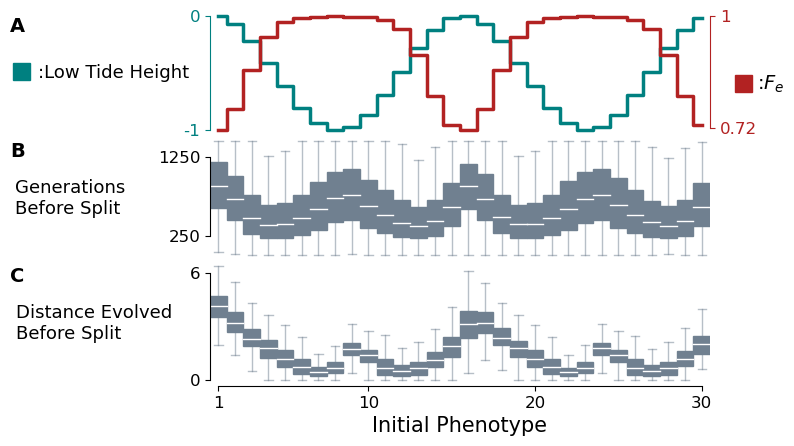

In [64]:
fig = plt.figure(figsize = (5,5))

ax3 = fig.add_axes([0,0.75,1,0.25])
ax3_mir = fig.add_axes([0,0.75,1,0.25])
ax4 = fig.add_axes([0,0.5,1,0.25])
ax5 = fig.add_axes([0,0.25,1,0.25])



Xs = np.linspace(1,30,30)
Ys = ((np.sin(2*np.pi*(Xs/15) - 5))/2 - 0.5)
Fe = 1/(2+np.exp(6*Ys + 1)) + 0.5

ax3.step(Xs,Ys,where = 'mid', c = 'teal', lw = 2.5)
ax3.set_xlim(0.5,30.5)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_bounds(-1,0)
ax3.spines['left'].set_color('teal')
ax3.set_yticks([-1,0],[-1,0], fontsize = 12, color = 'teal')
ax3.tick_params(color = 'teal')
ax3.set_ylabel(':Low Tide Height', fontsize = 13, rotation = 0, ha ='left', va = 'center', labelpad = 105)
#ax3.add_patch(Rectangle((-10.2,-0.55),1,0.15,color = 'teal',clip_on = False))
ax3.add_patch(Rectangle((-11.3,-0.56),1,0.15,color = 'teal',clip_on = False))

ax3_mir.step(Xs,Fe,where = 'mid', c = 'firebrick', lw = 2.5)
ax3_mir.set_xlim(0.5,30.5)
ax3_mir.patch.set_alpha(0)
ax3_mir.yaxis.set_label_position("right")
ax3_mir.yaxis.tick_right()
ax3_mir.spines['top'].set_visible(False)
ax3_mir.spines['left'].set_visible(False)
ax3_mir.spines['bottom'].set_visible(False)
ax3_mir.spines['right'].set_bounds(0.72,1)
ax3_mir.spines['right'].set_color('firebrick')
ax3_mir.set_yticks([0.72,1],[0.72,1], fontsize = 12, color = 'firebrick')
ax3_mir.tick_params(color = 'firebrick')
ax3_mir.set_ylabel(':$F_e$', fontsize=14, rotation = 0, labelpad = 10)
ax3_mir.add_patch(Rectangle((32,0.81),1,0.043,color = 'firebrick',clip_on = False))


for i in range(30):
    a = split_time[i]
    ax4.boxplot(a[~np.isnan(a)], positions = [i], widths = [1], showfliers = False,patch_artist=True,
            boxprops=dict(facecolor='slategrey', color='slategrey'),
            capprops=dict(color='slategrey', alpha = 0.5),
            whiskerprops=dict(color='slategrey', alpha = 0.5),
            medianprops=dict(color='white'))
ax4.set_xticks([])
ax4.set_xlim(-0.5,29.5)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_bounds(250,1250)
ax4.set_yticks([250,1250],[250,1250], fontsize = 12)
ax4.set_ylabel('Generations\nBefore Split', fontsize = 13, rotation = 0, ha ='left', va = 'center', labelpad = 103)


for i in range(30):
    b = evolved_dist[i]
    ax5.boxplot(abs(b[~np.isnan(b)]), positions = [i], widths = [1], showfliers = False,patch_artist=True,
            boxprops=dict(facecolor='slategrey', color='slategrey'),
            capprops=dict(color='slategrey', alpha = 0.5),
            whiskerprops=dict(color='slategrey', alpha = 0.5),
            medianprops=dict(color='white'))  
ax5.set_xticks([])
ax5.set_xlim(-0.5,29.5)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_bounds(0,29)
ax5.spines['left'].set_bounds(0,6)
ax5.set_yticks([0,6],[0,6], fontsize = 12)
ax5.set_ylabel('Distance Evolved\nBefore Split', fontsize = 13, rotation = 0, ha ='left', va = 'center', labelpad = 125)
ax5.set_xticks([0,9,19,29],['1','10','20','30'], fontsize = 12)
ax5.set_xlabel('Initial Phenotype', fontsize = 15)



plt.annotate('A',(-12.5,19.5), fontsize = 14, fontweight = 'bold', annotation_clip = False)
plt.annotate('B',(-12.5,12.5), fontsize = 14, fontweight = 'bold', annotation_clip = False)
plt.annotate('C',(-12.5,5.5), fontsize = 14, fontweight = 'bold', annotation_clip = False)

plt.savefig('plots/initial_states_suppliment.pdf', bbox_inches = 'tight')

/Users/jacobsen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/Users/jacobsen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Low Tide\nHeight')

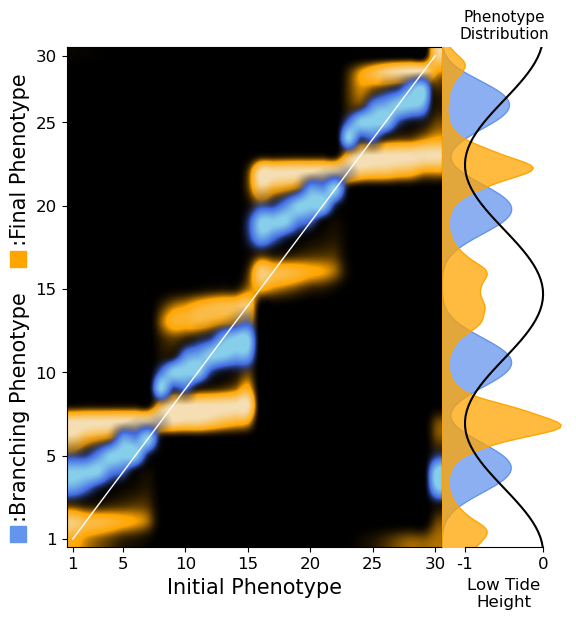

In [1778]:
cmap1 = LinearSegmentedColormap.from_list("mycmap", ['none','royalblue','skyblue'])
cmap2 = LinearSegmentedColormap.from_list("mycmap", ['none','orange','wheat'])


fig = plt.figure(figsize = (5,5))

ax1 = fig.add_axes([0,0,0.75,1])
ax2 = fig.add_axes([0.75,0,0.25,1])
ax3 = fig.add_axes([0.75,0,0.25,1])


a_flipped = np.flipud(final_pheno_sum.transpose())/np.flipud(final_pheno_sum.transpose()).max(axis = 0)
ax1.imshow(a_flipped,cmap = cmap2, interpolation = 'spline16', aspect = 'auto')
b = np.zeros((30,30))
for i in range(1,31,1):
    b[:,i-1] = np.histogram(branching_pheno[i-1], bins = 30, range = (0,30))[0]
b = np.hstack((b[:,1:],b[:,0][:,np.newaxis]))
b = np.vstack((b[1:,:],b[0,:][np.newaxis,:]))
b_flipped = np.flipud(b)/np.flipud(b).max(axis = 0)
ax1.imshow(b_flipped, cmap = cmap1, interpolation = 'spline16', aspect = 'auto')


ax1.plot(np.linspace(0,29,29),np.linspace(29,0,29),c = 'white', lw = 1)

ax1.set_facecolor('black')
ax1.set_xlabel('Initial Phenotype', fontsize = 15)
ax1.set_ylabel(':Branching Phenotype       :Final Phenotype', fontsize = 15)
ax1.set_yticks([29,24,19,14,9,4,0],['1','5','10','15','20','25','30'], fontsize = 12)
ax1.set_xticks([0,4,9,14,19,24,29],['1','5','10','15','20','25','30'], fontsize = 12)
ax1.add_patch(Rectangle((-5,28.2),1.25,1,color = 'cornflowerblue',clip_on = False))
ax1.add_patch(Rectangle((-5,11.7),1.25,1,color = 'orange',clip_on = False))


l = []
for i, val in enumerate(b.sum(axis = 1)/10):
    l = l + [i]*int(val)
sns.kdeplot(l, bw_adjust = 0.75, fill = True, color = 'cornflowerblue', alpha = 0.75, ax = ax2, vertical = True)

l = []
for i, val in enumerate(final_pheno_sum.transpose().sum(axis = 1)/500):
    l = l + [i]*int(val)
sns.kdeplot(l, bw_adjust = 0.75, fill = True, color = 'orange', alpha = 0.75, ax = ax2, vertical = True)
ax2.set_ylim(0,29)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
#ax2.spines['bottom'].set_bounds(0.0,0.1)
#ax2.set_xticks([0,0.1],['','0.1'])
ax2.spines['bottom'].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_title('Phenotype\nDistribution', fontsize = 11)


Xs = np.linspace(1,30,100)
Ys = ((np.sin(2*np.pi*(Xs/15) - 5))/2 - 0.5)
Fe = 1/(2+np.exp(6*Ys + 1)) + 0.5
ax3.patch.set_alpha(0)
ax3.plot(Ys,Xs, c = 'black', lw = 1.5)
ax3.set_xlim(-1.3,0.3)
ax3.set_ylim(1,30)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_bounds(-1,0)
ax3.set_xticks([-1,0],[-1,0], fontsize = 12)
ax3.set_yticks([])
ax3.set_xlabel('Low Tide\nHeight', fontsize = 12)



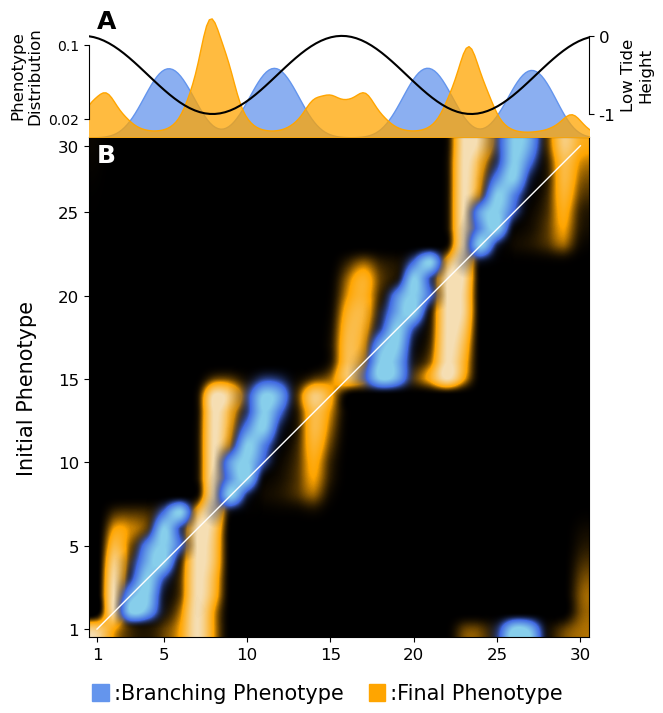

In [1872]:
cmap1 = LinearSegmentedColormap.from_list("mycmap", ['none','royalblue','skyblue'])
cmap2 = LinearSegmentedColormap.from_list("mycmap", ['none','orange','wheat'])


fig = plt.figure(figsize = (5,5))

ax1 = fig.add_axes([0,0,1,1])
ax2 = fig.add_axes([0,1,1,0.25])
ax3 = fig.add_axes([0,1,1,0.25])

a_flipped = np.flipud(final_pheno_sum.transpose())/np.flipud(final_pheno_sum.transpose()).max(axis = 0)
ax1.imshow(a_flipped.transpose(),
           cmap = cmap2, interpolation = 'spline16', aspect = 'auto')
b = np.zeros((30,30))
for i in range(1,31,1):
    b[:,i-1] = np.histogram(branching_pheno[i-1], bins = 30, range = (0,30))[0]
b = np.hstack((b[:,1:],b[:,0][:,np.newaxis]))
b = np.vstack((b[1:,:],b[0,:][np.newaxis,:]))
b_flipped = np.flipud(b)/np.flipud(b).max(axis = 0)
ax1.imshow(b_flipped.transpose(), cmap = cmap1, interpolation = 'spline16', aspect = 'auto')


ax1.plot(np.linspace(0,29,29),np.linspace(29,0,29),c = 'white', lw = 1)

ax1.set_facecolor('black')
ax1.set_ylabel('Initial Phenotype', fontsize = 15, labelpad = 15)
ax1.set_xlabel(':Branching Phenotype       :Final Phenotype', fontsize = 15, labelpad = 15)
ax1.set_yticks([29,24,19,14,9,4,0],['1','5','10','15','20','25','30'], fontsize = 12)
ax1.set_xticks([0,4,9,14,19,24,29],['1','5','10','15','20','25','30'], fontsize = 12)
ax1.add_patch(Rectangle((-0.3,32.3),1,1,color = 'cornflowerblue',clip_on = False))
ax1.add_patch(Rectangle((16.3, 32.3),1,1,color = 'orange',clip_on = False))


l = []
for i, val in enumerate(b.sum(axis = 1)/10):
    l = l + [i]*int(val)
sns.kdeplot(l, bw_adjust = 0.75, fill = True, color = 'cornflowerblue', alpha = 0.75, ax = ax2)

l = []
for i, val in enumerate(final_pheno_sum.transpose().sum(axis = 1)/500):
    l = l + [i]*int(val)
sns.kdeplot(l, bw_adjust = 0.75, fill = True, color = 'orange', alpha = 0.75, ax = ax2)
ax2.set_xlim(0,29)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_bounds(0.02,0.1)
ax2.set_yticks([0.02,0.1],['0.02','0.1'])
ax2.set_xticks([])
ax2.set_ylabel('Phenotype\nDistribution', fontsize = 12)


Xs = np.linspace(1,30,100)
Ys = ((np.sin(2*np.pi*(Xs/15) - 5))/2 - 0.5)
Fe = 1/(2+np.exp(6*Ys + 1)) + 0.5
ax3.patch.set_alpha(0)
ax3.plot(Xs,Ys, c = 'black', lw = 1.5)
ax3.set_ylim(-1.3,0.3)
ax3.set_xlim(1,30)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_bounds(-1,0)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.set_yticks([-1,0],[-1,0], fontsize = 12)
ax3.set_xticks([])
ax3.set_ylabel('Low Tide\nHeight', fontsize = 12)

ax3.annotate('A', (1.5,0.1), annotation_clip = False, fontweight = 'bold', fontsize = 18)
ax1.annotate('B', (0,1), annotation_clip = False, fontweight = 'bold', 
             fontsize = 18, color = 'white')

plt.savefig('plots/initial_states_singlePanel.pdf', bbox_inches = 'tight')

# Figure 6 - Fitness Functions

Text(0, 0.5, '$F_e$')

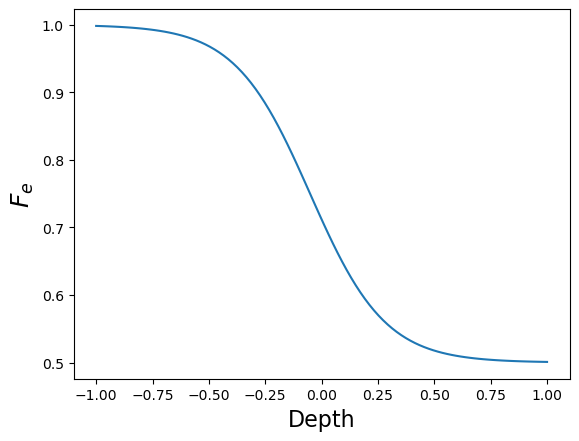

In [1761]:
# Current Fitness Function
Ys = np.linspace(-1,1,100)
Fe = 1/(2+np.exp(6*Ys + 1)) + 0.5
plt.plot(Ys,Fe)
plt.xlabel('Depth', fontsize = 16)
plt.ylabel('$F_e$', fontsize = 18)

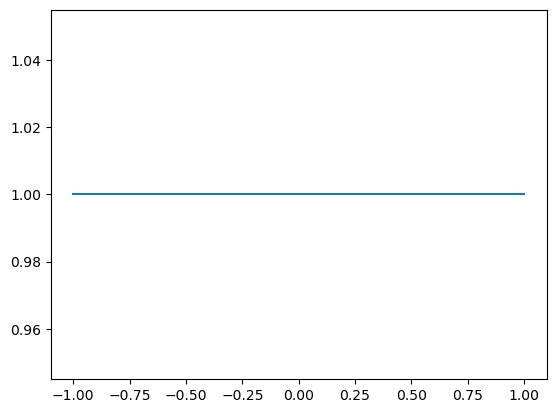

In [1282]:
# Flat Fitness Function
Ys = np.linspace(-1,1,100)
Fe = [1]*100
plt.plot(Ys,Fe)

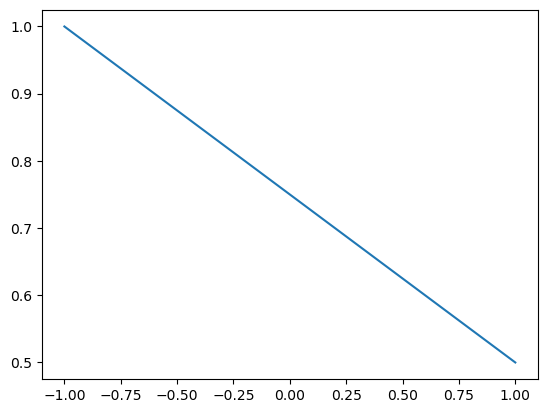

In [1295]:
# Linear Fitness Function
Ys = np.linspace(-1,1,100)
Fe = -0.25*Ys + 0.75
plt.plot(Ys,Fe)

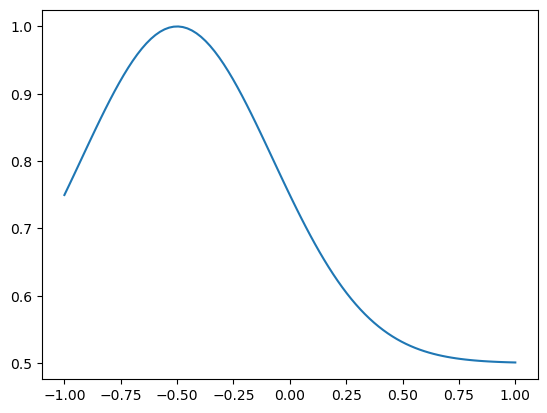

In [1336]:
# Unimodal Fitness Function
Ys = np.linspace(-1,1,100)
Fe = np.exp((-(-0.5 - Ys)**2)/(2*0.3)**2)/2 + 0.5
plt.plot(Ys,Fe)

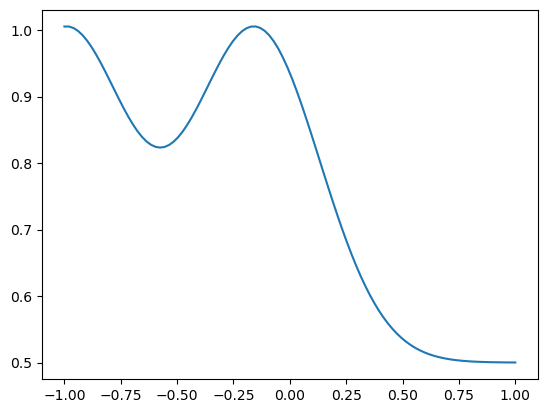

In [1335]:
# Bimodal Fitness Function
Ys = np.linspace(-1,1,100)
Fe = (np.exp((-(-1 - Ys)**2)/(2*0.2)**2) + np.exp((-(-0.15 - Ys)**2)/(2*0.2)**2))/2 + 0.5
plt.plot(Ys,Fe)

In [5]:
files = glob('CwSd_ParamSweeps/Gen_CwSd_paramSweep_10kids_200K/*')
sigmoid = np.load(files.pop(0))[None,:,:]
for file in files:
    sigmoid = np.concatenate((sigmoid,np.load(file)[None,:,:]),axis = 0)

files = glob('Fitness_Functions/flat/*')
flat = np.load(files.pop(0))[None,:,:]
for file in files:
    flat = np.concatenate((flat,np.load(file)[None,:,:]),axis = 0)

files = glob('Fitness_Functions/linear/*')
linear = np.load(files.pop(0))[None,:,:]
for file in files:
    linear = np.concatenate((linear,np.load(file)[None,:,:]),axis = 0)
    
files = glob('Fitness_Functions/unimodal/*')
unimodal = np.load(files.pop(0))[None,:,:]
for file in files:
    unimodal = np.concatenate((unimodal,np.load(file)[None,:,:]),axis = 0)
    
files = glob('Fitness_Functions/bimodal/*')
bimodal = np.load(files.pop(0))[None,:,:]
for file in files:
    bimodal = np.concatenate((bimodal,np.load(file)[None,:,:]),axis = 0)

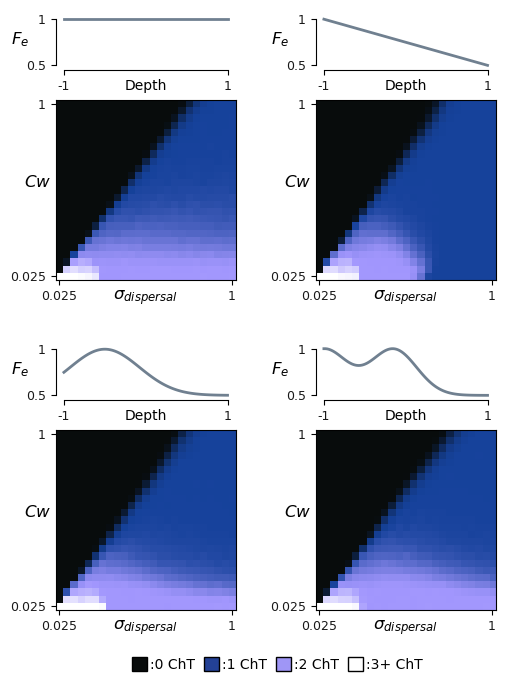

In [6]:
Ys = np.linspace(-1,1,100)

fig = plt.figure(figsize = (4,6))

ax1 = fig.add_axes([0,0.5,0.45,0.3])
ax1b = fig.add_axes([0,0.85,0.45,0.1])

ax2 = fig.add_axes([0.65,0.5,0.45,0.3])
ax2b = fig.add_axes([0.65,0.85,0.45,0.1])

ax3 = fig.add_axes([0,-0.05,0.45,0.3])
ax3b = fig.add_axes([0,0.3,0.45,0.1])

ax4 = fig.add_axes([0.65,-0.05,0.45,0.3])
ax4b = fig.add_axes([0.65,0.3,0.45,0.1])

ax1.imshow(np.flipud(flat.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')
Fe = [1]*100
ax1b.plot(Ys,Fe, c = 'slategrey', lw = 2)

ax2.imshow(np.flipud(linear.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')
Fe = -0.25*Ys + 0.75
ax2b.plot(Ys,Fe, c = 'slategrey', lw = 2)

ax3.imshow(np.flipud(unimodal.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')
Fe = np.exp((-(-0.5 - Ys)**2)/(2*0.3)**2)/2 + 0.5
ax3b.plot(Ys,Fe, c = 'slategrey', lw = 2)

ax4.imshow(np.flipud(bimodal.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')
Fe = (np.exp((-(-1 - Ys)**2)/(2*0.2)**2) + np.exp((-(-0.15 - Ys)**2)/(2*0.2)**2))/2 + 0.5
ax4b.plot(Ys,Fe, c = 'slategrey', lw = 2)

    
for ax in [ax1b,ax2b,ax3b,ax4b]:
    ax.set_ylim(0.45,1.1)
    ax.set_xticks([-1,1],['-1','1'], fontsize = 9, alpha = 0.9)
    ax.set_yticks([0.5,1],[0.5,1], fontsize = 9, alpha = 0.9)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds(0.5,1)
    ax.spines['bottom'].set_bounds(-1,1)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Depth', fontsize = 10, labelpad = -10)
    ax.set_ylabel('$F_e$', rotation=0, fontsize = 12, va = 'center')
    
for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xticks([0,24],['0.025','1'], fontsize = 9, alpha = 0.9)
    ax.set_yticks([24,0],['0.025','1'], fontsize = 9, alpha = 0.9)
    ax.set_xlabel('$\sigma_{dispersal}$', fontsize = 12, labelpad = -10)
    ax.set_ylabel('$Cw$', fontsize = 12, labelpad = -20, rotation = 0)
    
    

# ax1b.annotate('A', (-1.05,1.15), annotation_clip = False, fontweight = 'bold', fontsize = 14)
# ax1.annotate('B', (0,2.5), annotation_clip = False, fontweight = 'bold', fontsize = 14, color = 'white')

# ax2b.annotate('C', (-1.05,1.15), annotation_clip = False, fontweight = 'bold', fontsize = 14)
# ax2.annotate('D', (0,2.5), annotation_clip = False, fontweight = 'bold', fontsize = 14, color = 'white')

# ax3b.annotate('E', (-1.05,1.15), annotation_clip = False, fontweight = 'bold', fontsize = 14)
# ax3.annotate('F', (0,2.5), annotation_clip = False, fontweight = 'bold', fontsize = 14, color = 'white')

# ax4b.annotate('G', (-1.05,1.15), annotation_clip = False, fontweight = 'bold', fontsize = 14)
# ax4.annotate('H', (0,2.5), annotation_clip = False, fontweight = 'bold', fontsize = 14, color = 'white')

ax4.add_patch(Rectangle((-26, 31),2,2, clip_on = False, facecolor = (9/255,12/255,12/255), edgecolor = 'black'))
ax4.annotate(':0 ChT',(-23.5,32.7), annotation_clip = False)

ax4.add_patch(Rectangle((-16, 31),2,2, clip_on = False, facecolor = (35/255,65/255,150/255), edgecolor = 'black'))
ax4.annotate(':1 ChT',(-13.5,32.7), annotation_clip = False)

ax4.add_patch(Rectangle((-6, 31),2,2, clip_on = False, facecolor = (159/255,150/255,246/255), edgecolor = 'black'))
ax4.annotate(':2 ChT',(-3.5,32.7), annotation_clip = False)

ax4.add_patch(Rectangle((4, 31),2,2, clip_on = False, facecolor = (1,1,1), edgecolor = 'black'))
ax4.annotate(':3+ ChT',(6.5,32.7), annotation_clip = False)



plt.savefig('plots/fitness_functions_noLabel.pdf', bbox_inches = 'tight')

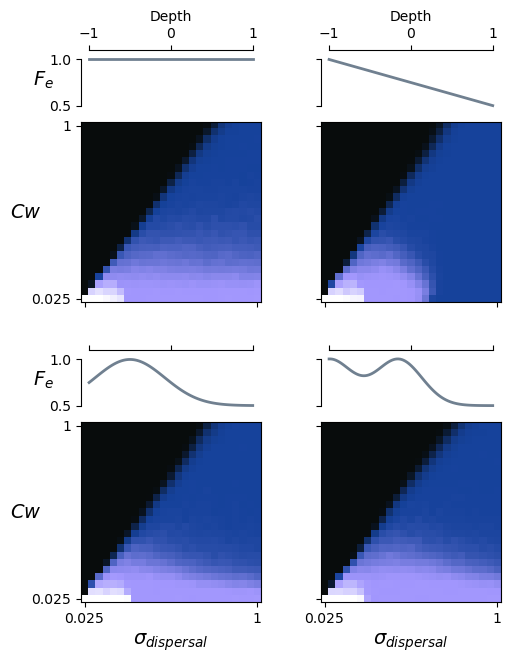

In [1449]:
Ys = np.linspace(-1,1,100)

fig = plt.figure(figsize = (4,6))

ax1 = fig.add_axes([0,0.5,0.45,0.3])
ax1b = fig.add_axes([0,0.82,0.45,0.1])

ax2 = fig.add_axes([0.6,0.5,0.45,0.3])
ax2b = fig.add_axes([0.6,0.82,0.45,0.1])

ax3 = fig.add_axes([0,0,0.45,0.3])
ax3b = fig.add_axes([0,0.32,0.45,0.1])

ax4 = fig.add_axes([0.6,0,0.45,0.3])
ax4b = fig.add_axes([0.6,0.32,0.45,0.1])

ax1.imshow(np.flipud(flat.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')
ax1.set_ylabel('$Cw$', rotation=0, fontsize = 14, va = 'center')
ax1.set_yticks([24,0],['0.025','1'])
ax1.set_xticks([0,24],['',''])
Fe = [1]*100
ax1b.plot(Ys,Fe, c = 'slategrey', lw = 2)
ax1b.set_ylabel('$F_e$', rotation=0, fontsize = 14, va = 'center')
ax1b.set_xlabel('Depth')

ax2.imshow(np.flipud(linear.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')
ax2.set_yticks([24,0],['',''])
ax2.set_xticks([0,24],['',''])
Fe = -0.25*Ys + 0.75
ax2b.plot(Ys,Fe, c = 'slategrey', lw = 2)
ax2b.set_xlabel('Depth')
ax2b.set_yticks([0.5,1],['',''])

ax3.imshow(np.flipud(unimodal.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')
ax3.set_ylabel('$Cw$', rotation=0, fontsize = 14, va = 'center')
ax3.set_xlabel('$\sigma_{dispersal}$',fontsize = 14) 
ax3.set_xticks([0,24],['0.025','1'])
ax3.set_yticks([24,0],['0.025','1'])
Fe = np.exp((-(-0.5 - Ys)**2)/(2*0.3)**2)/2 + 0.5
ax3b.plot(Ys,Fe, c = 'slategrey', lw = 2)
ax3b.set_ylabel('$F_e$', rotation=0, fontsize = 14, va = 'center')
ax3b.set_xticks([-1,0,1],['','',''])

ax4.imshow(np.flipud(bimodal.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')
ax4.set_xlabel('$\sigma_{dispersal}$',fontsize = 14) 
ax4.set_xticks([0,24],['0.025','1'])
ax4.set_yticks([24,0],['',''])
Fe = (np.exp((-(-1 - Ys)**2)/(2*0.2)**2) + np.exp((-(-0.15 - Ys)**2)/(2*0.2)**2))/2 + 0.5
ax4b.plot(Ys,Fe, c = 'slategrey', lw = 2)
ax4b.set_xticks([-1,0,1],['','',''])
ax4b.set_yticks([0.5,1],['',''])

for ax in [ax1b,ax2b,ax3b,ax4b]:
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_ylim(0.45,1.1)
    ax.spines['top'].set_bounds(-1,1)
    ax.spines['left'].set_bounds(0.5,1)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
# for ax in [ax1b,ax2b,ax3b,ax4b]:
#     ax.set_ylim(0.45,1.1)
#     ax.set_xticks([-1,1],['-1','1'])
#     ax.spines['top'].set_visible(False)
#     ax.spines['left'].set_bounds(0.5,1)
#     ax.spines['bottom'].set_bounds(-1,1)
#     ax.spines['right'].set_visible(False)
    


(-1.1, 1.1, 0.47485754051126294, 1.0308209387230522)

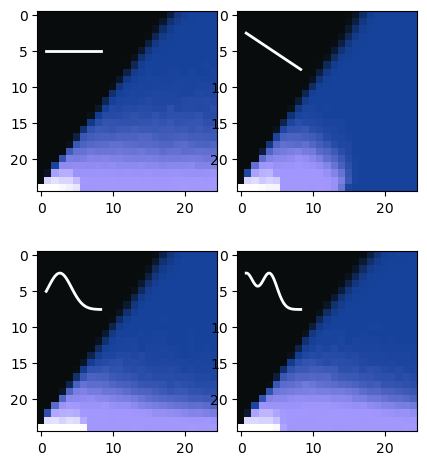

In [1482]:
Ys = np.linspace(-1,1,100)

fig = plt.figure(figsize = (4,4))

ax1 = fig.add_axes([0,0.6,0.45,0.45])
ax1b = fig.add_axes([0.015,0.9,0.15,0.1])

ax2 = fig.add_axes([0.5,0.6,0.45,0.45])
ax2b = fig.add_axes([0.515,0.9,0.15,0.1])

ax3 = fig.add_axes([0,0,0.45,0.45])
ax3b = fig.add_axes([0.015,0.3,0.15,0.1])

ax4 = fig.add_axes([0.5,0,0.45,0.45])
ax4b = fig.add_axes([0.515,0.3,0.15,0.1])

ax1.imshow(np.flipud(flat.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')

Fe = [1]*100
ax1b.plot(Ys,Fe, c = 'white', lw = 2)
ax1b.axis('off')

ax2.imshow(np.flipud(linear.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')
Fe = -0.25*Ys + 0.75
ax2b.plot(Ys,Fe, c = 'white', lw = 2)
ax2b.axis('off')

ax3.imshow(np.flipud(unimodal.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')
Fe = np.exp((-(-0.5 - Ys)**2)/(2*0.3)**2)/2 + 0.5
ax3b.plot(Ys,Fe, c = 'white', lw = 2)
ax3b.axis('off')

ax4.imshow(np.flipud(bimodal.mean(axis = 0)),cmap = blues, vmax = 3, aspect = 'auto')
Fe = (np.exp((-(-1 - Ys)**2)/(2*0.2)**2) + np.exp((-(-0.15 - Ys)**2)/(2*0.2)**2))/2 + 0.5
ax4b.plot(Ys,Fe, c = 'white', lw = 2)
ax4b.axis('off')